In [1]:
"""
🏆 AeroGuard RUL - Competition-Winning Solution
================================================
NASA C-MAPSS FD001 | Hybrid CNN-Attention-LSTM | Safety-Weighted Loss

Enhancements over baseline:
- ✅ Unit ID-based validation split (prevents temporal data leakage)
- ✅ Bahdanau-style Attention Layer (weights critical time-steps)
- ✅ Asymmetric Safety Loss (penalizes late predictions 3x more)
- ✅ Interactive Engine Gauge (Plotly visualization for judges)

Convert to notebook:
    jupyter nbconvert --to notebook --execute aeroguard_winning_solution.py
"""

'\n🏆 AeroGuard RUL - Competition-Winning Solution\n================================================\nNASA C-MAPSS FD001 | Hybrid CNN-Attention-LSTM | Safety-Weighted Loss\n\nEnhancements over baseline:\n- ✅ Unit ID-based validation split (prevents temporal data leakage)\n- ✅ Bahdanau-style Attention Layer (weights critical time-steps)\n- ✅ Asymmetric Safety Loss (penalizes late predictions 3x more)\n- ✅ Interactive Engine Gauge (Plotly visualization for judges)\n\nConvert to notebook:\n    jupyter nbconvert --to notebook --execute aeroguard_winning_solution.py\n'

# 🏆 AeroGuard RUL - Competition-Winning Solution

**NASA C-MAPSS FD001 | Hybrid CNN-Attention-LSTM | Safety-Weighted Loss**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout,
    BatchNormalization, Layer
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [3]:
# Dataset path
DATA_DIR = '../datasets/CMAPSSData'
MODEL_DIR = '../models'

# Column names
COLUMN_NAMES = ['unit', 'time'] + [f'op{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]

# Sensors to drop (constant values)
SENSORS_TO_DROP = ['sensor1', 'sensor5', 'sensor10', 'sensor16', 'sensor18', 'sensor19', 'op3']

# Hyperparameters
MAX_RUL_CAP = 125
SEQUENCE_LENGTH = 30
EPOCHS = 80  # Updated as requested
BATCH_SIZE = 256
VAL_SPLIT_RATIO = 0.2  # 20% of units held out for validation

os.makedirs(MODEL_DIR, exist_ok=True)

# Load datasets
train_df = pd.read_csv(f'{DATA_DIR}/train_FD001.txt', sep=r'\s+', header=None, names=COLUMN_NAMES)
test_df = pd.read_csv(f'{DATA_DIR}/test_FD001.txt', sep=r'\s+', header=None, names=COLUMN_NAMES)
rul_df = pd.read_csv(f'{DATA_DIR}/RUL_FD001.txt', header=None, names=['RUL'])

print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print(f"RUL labels: {rul_df.shape}")

Training data: (20631, 26)
Test data: (13096, 26)
RUL labels: (100, 1)


In [4]:
def add_rul_labels(df, max_rul_cap=MAX_RUL_CAP):
    """Add RUL labels with piecewise linear capping."""
    df = df.copy()
    rul_list = []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit]
        max_cycle = unit_df['time'].max()
        rul = max_cycle - unit_df['time']
        rul_list.extend(rul.tolist())
    df['RUL'] = rul_list
    df['RUL'] = df['RUL'].clip(upper=max_rul_cap)
    return df

train_df = add_rul_labels(train_df)
print("RUL distribution:")
print(train_df['RUL'].describe())

RUL distribution:
count    20631.000000
mean        86.829286
std         41.673699
min          0.000000
25%         51.000000
50%        103.000000
75%        125.000000
max        125.000000
Name: RUL, dtype: float64


In [5]:
# Drop constant sensors
cols_to_drop = [col for col in SENSORS_TO_DROP if col in train_df.columns]
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# Get feature columns
feature_cols = [col for col in train_df.columns if col.startswith('sensor') or col.startswith('op')]
print(f"Feature columns ({len(feature_cols)}): {feature_cols}")

# Normalize data
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

Feature columns (17): ['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21']


## 🔬 Unit ID-Based Validation Split

**Why?** A time-step split allows the model to see adjacent cycles of the same engine 
in both training and validation sets, causing **temporal data leakage**.

**Solution:** Randomly hold out 20% of *engines* (not samples) for validation.

In [6]:
def create_sequences(df, sequence_length, is_test=False):
    """Create 3D sequences for CNN-LSTM."""
    sequences, labels, engine_ids = [], [], []
    
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].sort_values('time')
        data = unit_df[feature_cols].values
        
        if is_test:
            if len(data) >= sequence_length:
                sequences.append(data[-sequence_length:])
                engine_ids.append(unit)
        else:
            rul_values = unit_df['RUL'].values
            for i in range(len(data) - sequence_length + 1):
                sequences.append(data[i:i + sequence_length])
                labels.append(rul_values[i + sequence_length - 1])
                engine_ids.append(unit)
    
    X = np.array(sequences)
    if is_test:
        return X, np.array(engine_ids)
    return X, np.array(labels), np.array(engine_ids)


# ========== UNIT ID-BASED SPLIT (THE KEY FIX) ==========
np.random.seed(42)  # Reproducibility
all_units = train_df['unit'].unique()
n_val_units = int(len(all_units) * VAL_SPLIT_RATIO)
val_units = np.random.choice(all_units, size=n_val_units, replace=False)
train_units = np.array([u for u in all_units if u not in val_units])

print(f"Total units: {len(all_units)}")
print(f"Training units ({len(train_units)}): {sorted(train_units)[:10]}... (showing first 10)")
print(f"Validation units ({len(val_units)}): {sorted(val_units)}")

# Split the dataframe by unit BEFORE creating sequences
train_split_df = train_df[train_df['unit'].isin(train_units)]
val_split_df = train_df[train_df['unit'].isin(val_units)]

# Create sequences from the split dataframes
X_train, y_train, train_ids = create_sequences(train_split_df, SEQUENCE_LENGTH, is_test=False)
X_val, y_val, val_ids = create_sequences(val_split_df, SEQUENCE_LENGTH, is_test=False)
X_test, test_ids = create_sequences(test_df, SEQUENCE_LENGTH, is_test=True)
y_test = rul_df['RUL'].values

print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\n✓ NO DATA LEAKAGE: Train and Val units are completely separate!")

Total units: 100
Training units (80): [np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(12), np.int64(14)]... (showing first 10)
Validation units (20): [np.int64(1), np.int64(5), np.int64(11), np.int64(13), np.int64(19), np.int64(23), np.int64(31), np.int64(32), np.int64(34), np.int64(40), np.int64(45), np.int64(46), np.int64(54), np.int64(71), np.int64(74), np.int64(77), np.int64(78), np.int64(81), np.int64(84), np.int64(91)]



X_train shape: (14241, 30, 17)
X_val shape: (3490, 30, 17)
X_test shape: (100, 30, 17)

✓ NO DATA LEAKAGE: Train and Val units are completely separate!


## 🧠 Bahdanau-Style Attention Layer

**What it does:** Allows the model to learn which of the 30 time-steps are most 
important for predicting RUL.

In [7]:
class BahdanauAttention(Layer):
    """
    Bahdanau-style Additive Attention for time-step weighting.
    
    Given LSTM output of shape (batch, time_steps, features),
    computes attention weights for each time-step and returns
    a weighted sum context vector.
    """
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.units = units
        self.W = Dense(units, use_bias=False)
        self.V = Dense(1, use_bias=False)
    
    def call(self, inputs):
        # inputs shape: (batch, time_steps, features)
        # Score shape: (batch, time_steps, 1)
        score = self.V(tf.nn.tanh(self.W(inputs)))
        
        # Attention weights: (batch, time_steps, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Context vector: weighted sum of inputs
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        
        return context_vector, attention_weights
    
    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

print("✓ BahdanauAttention layer defined")

✓ BahdanauAttention layer defined


## ⚠️ Custom Safety-Weighted Loss Function

**The Problem:** Standard MSE treats over-predictions and under-predictions equally.

**In Aviation Reality:**
- Predicting failure 10 days **LATE** = Catastrophe
- Predicting failure 10 days **EARLY** = Unnecessary maintenance

In [8]:
def safety_weighted_loss(y_true, y_pred):
    """
    Asymmetric loss function mimicking NASA S-Score.
    
    Late prediction (y_pred > y_true): Loss = exp(error/10) - 1
    Early prediction (y_pred < y_true): Loss = exp(-error/13) - 1
    
    Penalizes late predictions ~3x more severely.
    """
    error = y_pred - y_true
    
    # Late predictions (over-estimation of RUL)
    late_loss = tf.exp(error / 10.0) - 1.0
    
    # Early predictions (under-estimation of RUL)
    early_loss = tf.exp(-error / 13.0) - 1.0
    
    # Select appropriate loss based on error sign
    loss = tf.where(error >= 0, late_loss, early_loss)
    
    return tf.reduce_mean(loss)

# Quick test
test_true = tf.constant([50.0, 50.0])
test_pred = tf.constant([60.0, 40.0])  # 10 late, 10 early
test_loss = safety_weighted_loss(test_true, test_pred)
print(f"Test loss (10 late + 10 early): {test_loss.numpy():.4f}")
print("✓ Safety-weighted loss function defined")

Test loss (10 late + 10 early): 1.4382
✓ Safety-weighted loss function defined


## 🏗️ CNN-Attention-LSTM Hybrid Architecture

In [9]:
def build_attention_model(input_shape):
    """
    Build CNN-Attention-LSTM hybrid architecture.
    
    Args:
        input_shape: Tuple (sequence_length, n_features) = (30, 17)
    
    Returns:
        Compiled Keras model with Safety-Weighted Loss
    """
    inputs = Input(shape=input_shape, name='input')
    
    # ===== CNN Block: Spatial Pattern Extraction =====
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001), name='conv1d')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool')(x)
    x = Dropout(0.2, name='dropout_cnn')(x)
    
    # ===== LSTM Block: Temporal Sequence Processing =====
    x = LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001),
             name='lstm_1')(x)
    x = Dropout(0.3, name='dropout_lstm1')(x)
    
    # ===== Attention Block: Critical Time-Step Focus =====
    context_vector, attention_weights = BahdanauAttention(64, name='attention')(x)
    
    # ===== Output Block =====
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001),
              name='dense_1')(context_vector)
    x = Dropout(0.2, name='dropout_dense')(x)
    outputs = Dense(1, activation='linear', name='rul_output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='CNN_Attention_LSTM')
    
    # Compile with Safety-Weighted Loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=safety_weighted_loss,
        metrics=['mae']
    )
    
    return model

# Build and display model
model = build_attention_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "CNN_Attention_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30, 17)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool (MaxPooling1D)          │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_cnn (Dropout)           │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (BahdanauAttention)   │ [(None, 100), (None,   │         6,464 │
│                                 │ 15, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rul_output (Dense)              │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,577 (322.57 KB)

 Trainable params: 82,449 (322.07 KB)

 Non-trainable params: 128 (512.00 B)

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(f'{MODEL_DIR}/cnn_attention_lstm_model.keras', 
                    monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
]

print(f"Training for {EPOCHS} epochs with Safety-Weighted Loss...")
print(f"Training on {len(train_units)} engines, validating on {len(val_units)} engines\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Training for 80 epochs with Safety-Weighted Loss...
Training on 80 engines, validating on 20 engines



Epoch 1/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - loss: 5427.0762 - mae: 81.6414

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 5608.2632 - mae: 82.0701

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 5558.7031 - mae: 81.7635

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 5523.0586 - mae: 81.6333

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 5464.4575 - mae: 81.4207

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5418.4102 - mae: 81.2326

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 5368.9438 - mae: 81.0557

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 5327.8311 - mae: 80.9413

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 5287.9941 - mae: 80.8236

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 5248.5132 - mae: 80.7212

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 5206.0835 - mae: 80.5857

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 5163.6099 - mae: 80.4596

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 5123.1372 - mae: 80.3500

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 5081.3335 - mae: 80.2268

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 5039.1387 - mae: 80.1028

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4997.4155 - mae: 79.9974

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4955.4653 - mae: 79.8850

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4912.4321 - mae: 79.7651

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4869.3823 - mae: 79.6521

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4826.6631 - mae: 79.5365

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 4783.3491 - mae: 79.4151

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 4739.9668 - mae: 79.2898

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 4696.7495 - mae: 79.1643

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4653.2822 - mae: 79.0282

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 4609.8853 - mae: 78.8884

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4566.5757 - mae: 78.7450

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4523.3257 - mae: 78.5941

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4480.4541 - mae: 78.4410

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4437.8823 - mae: 78.2850

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 4395.6646 - mae: 78.1270

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 4353.9648 - mae: 77.9706

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 4312.6470 - mae: 77.8114

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4271.7480 - mae: 77.6477

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4231.2891 - mae: 77.4808

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4191.3848 - mae: 77.3131

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4151.9878 - mae: 77.1414

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4113.1401 - mae: 76.9674

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4074.9163 - mae: 76.7961

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4037.2539 - mae: 76.6228

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4000.1182 - mae: 76.4467

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3963.5693 - mae: 76.2708

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3927.6179 - mae: 76.0975

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3892.2202 - mae: 75.9229

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3857.4153 - mae: 75.7484

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3823.1904 - mae: 75.5737

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3789.5303 - mae: 75.3985

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3756.4504 - mae: 75.2239

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3723.9331 - mae: 75.0496

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3691.9639 - mae: 74.8760

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3660.5383 - mae: 74.7041

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3629.6323 - mae: 74.5322

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3599.2427 - mae: 74.3608

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3569.3552 - mae: 74.1894

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3539.9705 - mae: 74.0187

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3511.0713 - mae: 73.8475

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3482.8564 - mae: 73.6787


Epoch 1: val_loss improved from None to 227.44182, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 1931.0349 - mae: 64.3941 - val_loss: 227.4418 - val_mae: 48.6037 - learning_rate: 0.0010


Epoch 2/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 217.1798 - mae: 48.5046

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 213.4364 - mae: 47.6910

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 214.4237 - mae: 47.4122

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 214.0729 - mae: 47.2908

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 211.7665 - mae: 47.0938

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 210.5395 - mae: 46.9774

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 209.4711 - mae: 46.8889

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 208.1592 - mae: 46.8012

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 206.5025 - mae: 46.6927

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 204.9078 - mae: 46.5927

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 203.2808 - mae: 46.4905

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 201.6394 - mae: 46.3927

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 199.9359 - mae: 46.2952

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 198.3736 - mae: 46.2199

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 196.8208 - mae: 46.1398

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 195.2853 - mae: 46.0636

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 193.7027 - mae: 45.9765

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 192.1380 - mae: 45.8875

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 190.6330 - mae: 45.8058

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 189.1763 - mae: 45.7272

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 187.6964 - mae: 45.6402

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 186.2400 - mae: 45.5553

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 184.8234 - mae: 45.4749

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 183.4288 - mae: 45.3964

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 182.0599 - mae: 45.3203

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 180.7181 - mae: 45.2436

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 179.4073 - mae: 45.1689

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 178.1120 - mae: 45.0930

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 176.8483 - mae: 45.0191

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 175.6156 - mae: 44.9475

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 174.4270 - mae: 44.8797

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 173.2544 - mae: 44.8109

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 172.1102 - mae: 44.7442

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 170.9780 - mae: 44.6763

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 169.8706 - mae: 44.6104

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 168.7840 - mae: 44.5442

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 167.7234 - mae: 44.4810

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 166.6838 - mae: 44.4182

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 165.6564 - mae: 44.3548

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 164.6534 - mae: 44.2935

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 163.6667 - mae: 44.2330

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 162.6982 - mae: 44.1736

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 161.7449 - mae: 44.1148

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 160.8065 - mae: 44.0567

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 159.8849 - mae: 43.9996

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 158.9817 - mae: 43.9442

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 158.0895 - mae: 43.8889

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 157.2112 - mae: 43.8342

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 156.3438 - mae: 43.7791

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 155.4885 - mae: 43.7239

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 154.6496 - mae: 43.6702

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 153.8238 - mae: 43.6175

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 153.0111 - mae: 43.5656

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 152.2090 - mae: 43.5135

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 151.4170 - mae: 43.4615


Epoch 2: val_loss improved from 227.44182 to 74.33817, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 108.0507 - mae: 40.5887 - val_loss: 74.3382 - val_mae: 40.7919 - learning_rate: 0.0010


Epoch 3/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 58.8253 - mae: 37.6437

 2/56 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 57.7469 - mae: 37.4726

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 56.6453 - mae: 37.3325

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 55.5930 - mae: 37.0001

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 55.2429 - mae: 36.8596

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 54.9782 - mae: 36.7693

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 54.7969 - mae: 36.7065

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 54.5920 - mae: 36.6442

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 54.3581 - mae: 36.5770

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 54.1183 - mae: 36.5168

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 53.8787 - mae: 36.4590

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 53.6835 - mae: 36.4176

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 53.4777 - mae: 36.3734

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 53.2909 - mae: 36.3398

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 53.1681 - mae: 36.3151

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 53.0464 - mae: 36.2878

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 52.9301 - mae: 36.2615

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 52.8095 - mae: 36.2347

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 52.6775 - mae: 36.2069

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 52.5260 - mae: 36.1727

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 52.3784 - mae: 36.1397

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 52.2240 - mae: 36.1059

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 52.0641 - mae: 36.0709

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 51.9095 - mae: 36.0369

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 51.7615 - mae: 36.0041

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 51.6215 - mae: 35.9739

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 51.4792 - mae: 35.9445

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 51.3341 - mae: 35.9140

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 51.1843 - mae: 35.8805

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 51.0400 - mae: 35.8501

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 50.8914 - mae: 35.8183

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 50.7447 - mae: 35.7877

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 50.5979 - mae: 35.7566

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 50.4530 - mae: 35.7266

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 50.3093 - mae: 35.6971

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 50.1667 - mae: 35.6678

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 50.0294 - mae: 35.6393

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 49.8926 - mae: 35.6107

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 49.7565 - mae: 35.5827

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 49.6234 - mae: 35.5542

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 49.4909 - mae: 35.5259

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 49.3606 - mae: 35.4989

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 49.2318 - mae: 35.4729

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 49.1051 - mae: 35.4473

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.9787 - mae: 35.4219

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.8534 - mae: 35.3970

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.7309 - mae: 35.3734

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.6095 - mae: 35.3503

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.4894 - mae: 35.3268

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.3706 - mae: 35.3033

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.2531 - mae: 35.2800

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.1352 - mae: 35.2563

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 48.0198 - mae: 35.2329

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 47.9053 - mae: 35.2103

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 47.7912 - mae: 35.1879


Epoch 3: val_loss improved from 74.33817 to 51.35737, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 41.5163 - mae: 33.9648 - val_loss: 51.3574 - val_mae: 36.6726 - learning_rate: 0.0010


Epoch 4/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 32.5980 - mae: 31.5384

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 31.9082 - mae: 31.3074

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 32.1726 - mae: 31.4139

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 32.1798 - mae: 31.4910

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 32.1788 - mae: 31.5994

 6/56 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 32.1985 - mae: 31.6398

 7/56 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 32.0984 - mae: 31.6217

 8/56 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 31.9396 - mae: 31.5717

 9/56 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 31.7908 - mae: 31.5406

10/56 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 31.7120 - mae: 31.5378

11/56 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 31.6225 - mae: 31.5279

12/56 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 31.5479 - mae: 31.5251

13/56 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 31.4671 - mae: 31.5158

14/56 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 31.3979 - mae: 31.5116

15/56 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 31.3258 - mae: 31.5082

16/56 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 31.2731 - mae: 31.5045

17/56 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 31.2179 - mae: 31.4968

18/56 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 31.1654 - mae: 31.4896

19/56 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 31.1175 - mae: 31.4822

20/56 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 31.0579 - mae: 31.4667

21/56 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 31.0012 - mae: 31.4507

22/56 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 30.9491 - mae: 31.4366

23/56 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 30.8890 - mae: 31.4207

24/56 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 30.8252 - mae: 31.4034

25/56 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 30.7638 - mae: 31.3879

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 30.7013 - mae: 31.3725 

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 30.6372 - mae: 31.3556

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 30.5731 - mae: 31.3389

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 30.5079 - mae: 31.3208

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 30.4487 - mae: 31.3063

31/56 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 30.3909 - mae: 31.2933

32/56 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 30.3375 - mae: 31.2825

33/56 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 30.2819 - mae: 31.2707

34/56 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 30.2258 - mae: 31.2584

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 30.1697 - mae: 31.2464

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 30.1146 - mae: 31.2349

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 30.0557 - mae: 31.2207

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 29.9988 - mae: 31.2071

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 29.9437 - mae: 31.1950

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 29.8888 - mae: 31.1828

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 29.8355 - mae: 31.1708

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 29.7808 - mae: 31.1572

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 29.7260 - mae: 31.1424

44/56 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 29.6737 - mae: 31.1283

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 29.6217 - mae: 31.1141

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 29.5711 - mae: 31.1004

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 29.5219 - mae: 31.0864

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 29.4725 - mae: 31.0716

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 29.4238 - mae: 31.0565

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 29.3753 - mae: 31.0416

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 29.3284 - mae: 31.0268

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 29.2808 - mae: 31.0113

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 29.2333 - mae: 30.9959

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 29.1855 - mae: 30.9801

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 29.1372 - mae: 30.9636


Epoch 4: val_loss improved from 51.35737 to 27.86617, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 26.4750 - mae: 30.0448 - val_loss: 27.8662 - val_mae: 32.1133 - learning_rate: 0.0010


Epoch 5/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 19.0525 - mae: 27.0597

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 19.2418 - mae: 27.0704

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 19.4493 - mae: 27.1459

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 19.7418 - mae: 27.2554

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 20.0394 - mae: 27.4262

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 20.2366 - mae: 27.5185

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 20.3283 - mae: 27.5741

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 20.3894 - mae: 27.6107

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 20.4417 - mae: 27.6402

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 20.5060 - mae: 27.6831

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.5740 - mae: 27.7254

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.6176 - mae: 27.7500

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.6630 - mae: 27.7701

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 20.6913 - mae: 27.7888

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 20.7201 - mae: 27.8057

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 20.7340 - mae: 27.8142

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 20.7416 - mae: 27.8211

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.7340 - mae: 27.8195

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.7254 - mae: 27.8118

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.7157 - mae: 27.8021

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.7063 - mae: 27.7920

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.7001 - mae: 27.7847

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.6904 - mae: 27.7772

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 20.6816 - mae: 27.7705

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 20.6802 - mae: 27.7668

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.6762 - mae: 27.7625

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.6676 - mae: 27.7536

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.6578 - mae: 27.7456

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.6450 - mae: 27.7366

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.6284 - mae: 27.7255

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.6099 - mae: 27.7132

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.5926 - mae: 27.7027

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.5766 - mae: 27.6929

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 20.5596 - mae: 27.6822

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 20.5449 - mae: 27.6722

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 20.5307 - mae: 27.6618

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 20.5154 - mae: 27.6503

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 20.5019 - mae: 27.6397

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 20.4882 - mae: 27.6293

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 20.4764 - mae: 27.6197

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.4643 - mae: 27.6096

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.4519 - mae: 27.5992

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.4397 - mae: 27.5888

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.4266 - mae: 27.5785

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.4114 - mae: 27.5674

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.3953 - mae: 27.5565

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.3794 - mae: 27.5462

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.3628 - mae: 27.5354

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.3470 - mae: 27.5251

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.3312 - mae: 27.5149

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.3153 - mae: 27.5046

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.3008 - mae: 27.4954

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.2855 - mae: 27.4855

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.2697 - mae: 27.4757

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 20.2538 - mae: 27.4659


Epoch 5: val_loss improved from 27.86617 to 18.61780, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 19.3541 - mae: 26.9315 - val_loss: 18.6178 - val_mae: 28.4860 - learning_rate: 0.0010


Epoch 6/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - loss: 14.8517 - mae: 25.3365

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 15.4073 - mae: 25.3379

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 15.7442 - mae: 25.2688

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 15.8842 - mae: 25.2483

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 15.9442 - mae: 25.2452

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 16.0140 - mae: 25.2291

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 16.0565 - mae: 25.2283

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 16.0902 - mae: 25.2377

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 16.0798 - mae: 25.2403

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 16.0954 - mae: 25.2510

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.0898 - mae: 25.2497

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 16.0899 - mae: 25.2512

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 16.1060 - mae: 25.2545

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.1300 - mae: 25.2695

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 16.1482 - mae: 25.2800

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 16.1605 - mae: 25.2886

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.1714 - mae: 25.2974

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.1891 - mae: 25.3083

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.2148 - mae: 25.3166

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.2366 - mae: 25.3261

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.2512 - mae: 25.3288

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.2607 - mae: 25.3285

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.2706 - mae: 25.3282

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.2767 - mae: 25.3258

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 16.2812 - mae: 25.3222

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2842 - mae: 25.3203

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2825 - mae: 25.3157

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2807 - mae: 25.3111

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2764 - mae: 25.3049

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2728 - mae: 25.2973

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2684 - mae: 25.2898

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2628 - mae: 25.2819

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2552 - mae: 25.2727

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2463 - mae: 25.2626

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2364 - mae: 25.2522

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2284 - mae: 25.2432

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2197 - mae: 25.2347

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.2089 - mae: 25.2257

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.1992 - mae: 25.2173

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 16.1891 - mae: 25.2084

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1806 - mae: 25.2009

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1714 - mae: 25.1927

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1616 - mae: 25.1849

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1520 - mae: 25.1771

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1418 - mae: 25.1693

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1318 - mae: 25.1621

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1216 - mae: 25.1549

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1114 - mae: 25.1472

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.1006 - mae: 25.1395

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.0892 - mae: 25.1316

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.0800 - mae: 25.1249

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.0706 - mae: 25.1182

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.0618 - mae: 25.1118

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.0530 - mae: 25.1055

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 16.0445 - mae: 25.0994


Epoch 6: val_loss improved from 18.61780 to 13.15270, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 15.6153 - mae: 24.7980 - val_loss: 13.1527 - val_mae: 25.0870 - learning_rate: 0.0010


Epoch 7/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 12.0211 - mae: 23.6564

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 12.9028 - mae: 23.7998

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 13.6514 - mae: 23.9408

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 14.0553 - mae: 24.0501

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 14.2486 - mae: 24.1093

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 14.3680 - mae: 24.1542

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 14.4239 - mae: 24.1511

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 14.4961 - mae: 24.1406

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 14.5308 - mae: 24.1254

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 14.5607 - mae: 24.1167

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 14.5612 - mae: 24.0972

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 14.5456 - mae: 24.0720

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 14.5335 - mae: 24.0483

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 14.5150 - mae: 24.0242

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 14.4857 - mae: 23.9945

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 14.4638 - mae: 23.9679

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 14.4473 - mae: 23.9463

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 14.4346 - mae: 23.9272

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 14.4236 - mae: 23.9099

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 14.4123 - mae: 23.8959

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 14.4046 - mae: 23.8812

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 14.3968 - mae: 23.8670

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 14.3930 - mae: 23.8564

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 14.3860 - mae: 23.8455

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 14.3810 - mae: 23.8360

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 14.3733 - mae: 23.8277

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 14.3648 - mae: 23.8210

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 14.3550 - mae: 23.8137

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 14.3417 - mae: 23.8048

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 14.3277 - mae: 23.7951

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 14.3139 - mae: 23.7866

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.3015 - mae: 23.7777

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.2887 - mae: 23.7688

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.2742 - mae: 23.7593

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.2602 - mae: 23.7517

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.2470 - mae: 23.7449

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.2341 - mae: 23.7383

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.2209 - mae: 23.7323

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.2071 - mae: 23.7260

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.1922 - mae: 23.7192

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.1794 - mae: 23.7128

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 14.1668 - mae: 23.7066

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 14.1564 - mae: 23.7012

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 14.1455 - mae: 23.6955

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 14.1344 - mae: 23.6899

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 14.1228 - mae: 23.6841

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 14.1110 - mae: 23.6777

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 14.0994 - mae: 23.6716

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 14.0864 - mae: 23.6648

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 14.0734 - mae: 23.6578

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 14.0596 - mae: 23.6503

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 14.0468 - mae: 23.6425

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 14.0342 - mae: 23.6354

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 14.0221 - mae: 23.6283

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 14.0091 - mae: 23.6209

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 13.9957 - mae: 23.6132


Epoch 7: val_loss improved from 13.15270 to 10.66196, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 13.2588 - mae: 23.1910 - val_loss: 10.6620 - val_mae: 23.1839 - learning_rate: 0.0010


Epoch 8/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 12.4686 - mae: 22.2162

 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 12.4311 - mae: 22.5703 

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 12.6514 - mae: 22.7125

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 12.9215 - mae: 22.8506

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 13.1044 - mae: 22.9123

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 13.2076 - mae: 22.9426

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 13.2831 - mae: 22.9603

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 13.2749 - mae: 22.9405

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 13.2477 - mae: 22.9011

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 13.2419 - mae: 22.8786

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 13.2228 - mae: 22.8479

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 13.1952 - mae: 22.8127

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 13.1644 - mae: 22.7830

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 13.1292 - mae: 22.7522

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 13.1125 - mae: 22.7315

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 13.0886 - mae: 22.7102

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 13.0780 - mae: 22.6981

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 13.0680 - mae: 22.6850

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 13.0575 - mae: 22.6760

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 13.0417 - mae: 22.6670

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 13.0330 - mae: 22.6592

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 13.0255 - mae: 22.6529

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 13.0179 - mae: 22.6478

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 13.0088 - mae: 22.6419

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 12.9963 - mae: 22.6350

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 12.9851 - mae: 22.6276

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 12.9699 - mae: 22.6194

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 12.9543 - mae: 22.6119

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.9388 - mae: 22.6045

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.9247 - mae: 22.5999

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.9120 - mae: 22.5959

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8985 - mae: 22.5923

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8851 - mae: 22.5884

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8729 - mae: 22.5840

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8623 - mae: 22.5800

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8509 - mae: 22.5752

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8383 - mae: 22.5699

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8263 - mae: 22.5639

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8136 - mae: 22.5573

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.8013 - mae: 22.5515

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.7902 - mae: 22.5453

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7794 - mae: 22.5402

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7691 - mae: 22.5350

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7592 - mae: 22.5301

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7500 - mae: 22.5254

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7407 - mae: 22.5209

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7317 - mae: 22.5165

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7221 - mae: 22.5122

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7126 - mae: 22.5076

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.7039 - mae: 22.5037

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.6949 - mae: 22.5001

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.6860 - mae: 22.4961

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.6775 - mae: 22.4924

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.6688 - mae: 22.4884

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12.6602 - mae: 22.4845


Epoch 8: val_loss improved from 10.66196 to 8.57788, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 12.1758 - mae: 22.2619 - val_loss: 8.5779 - val_mae: 21.2370 - learning_rate: 0.0010


Epoch 9/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 9.8278 - mae: 19.8828

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 10.0739 - mae: 20.1630

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 10.4393 - mae: 20.4404

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 10.7065 - mae: 20.7107

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 11.0081 - mae: 20.9248

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 11.2253 - mae: 21.1062

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 11.3918 - mae: 21.2537

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 11.4664 - mae: 21.3421

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 11.4915 - mae: 21.3958

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 11.5536 - mae: 21.4457

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 11.5790 - mae: 21.4710

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 11.6098 - mae: 21.5020

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 11.6285 - mae: 21.5186

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 11.6385 - mae: 21.5313

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 11.6441 - mae: 21.5429

16/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 11.6487 - mae: 21.5542

17/56 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 11.6525 - mae: 21.5672

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 11.6531 - mae: 21.5741

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 11.6527 - mae: 21.5833

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 11.6533 - mae: 21.5918

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 11.6532 - mae: 21.5968

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.6502 - mae: 21.6012

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.6444 - mae: 21.6026

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.6381 - mae: 21.6043

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.6312 - mae: 21.6049

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.6238 - mae: 21.6033

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.6153 - mae: 21.6002

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.6063 - mae: 21.5966

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.5967 - mae: 21.5942

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 11.5859 - mae: 21.5909

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.5759 - mae: 21.5893

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.5669 - mae: 21.5889

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.5572 - mae: 21.5880

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.5472 - mae: 21.5865

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.5373 - mae: 21.5842

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.5282 - mae: 21.5820

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.5184 - mae: 21.5790

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.5075 - mae: 21.5752

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.4961 - mae: 21.5710

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.4852 - mae: 21.5665

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.4754 - mae: 21.5618

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.4664 - mae: 21.5582

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 11.4582 - mae: 21.5551

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.4513 - mae: 21.5524

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.4443 - mae: 21.5498

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.4361 - mae: 21.5463

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.4285 - mae: 21.5426

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.4210 - mae: 21.5380

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.4129 - mae: 21.5330

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.4048 - mae: 21.5280

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.3970 - mae: 21.5229

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 11.3899 - mae: 21.5187

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 11.3826 - mae: 21.5145

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 11.3750 - mae: 21.5101

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 11.3676 - mae: 21.5057

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 11.3606 - mae: 21.5017


Epoch 9: val_loss improved from 8.57788 to 7.18028, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 10.9757 - mae: 21.2860 - val_loss: 7.1803 - val_mae: 19.6184 - learning_rate: 0.0010


Epoch 10/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 9.1944 - mae: 19.7256

 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 9.3298 - mae: 19.9784 

 3/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 9.4393 - mae: 20.0362

 4/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 9.4314 - mae: 20.0218

 5/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 9.4189 - mae: 19.9912

 6/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 9.4970 - mae: 19.9963

 7/56 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 9.5877 - mae: 20.0040

 8/56 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 9.6505 - mae: 20.0168

 9/56 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 9.7061 - mae: 20.0386

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 9.7523 - mae: 20.0581

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 9.7932 - mae: 20.0893

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 9.8162 - mae: 20.1076

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 9.8412 - mae: 20.1325

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 9.8587 - mae: 20.1558

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 9.8692 - mae: 20.1702

16/56 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 9.8764 - mae: 20.1832

17/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 9.8814 - mae: 20.1943

18/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 9.8871 - mae: 20.2062

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 9.8895 - mae: 20.2168

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 9.8927 - mae: 20.2302

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 9.9055 - mae: 20.2472

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 9.9160 - mae: 20.2633

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 9.9264 - mae: 20.2774

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 9.9356 - mae: 20.2905

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 9.9445 - mae: 20.3033

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 9.9523 - mae: 20.3162

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 9.9602 - mae: 20.3281

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 9.9693 - mae: 20.3402

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 9.9774 - mae: 20.3503

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 9.9853 - mae: 20.3611

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.9921 - mae: 20.3722

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.9993 - mae: 20.3825

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.0062 - mae: 20.3919

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.0146 - mae: 20.4017

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.0213 - mae: 20.4095

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.0284 - mae: 20.4171

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.0346 - mae: 20.4246

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.0394 - mae: 20.4311

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.0434 - mae: 20.4372

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.0471 - mae: 20.4429

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.0502 - mae: 20.4484

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.0538 - mae: 20.4541

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 10.0574 - mae: 20.4596

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 10.0603 - mae: 20.4647

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 10.0632 - mae: 20.4698

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 10.0668 - mae: 20.4744

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 10.0691 - mae: 20.4778

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 10.0718 - mae: 20.4816

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 10.0747 - mae: 20.4852

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 10.0772 - mae: 20.4886

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 10.0791 - mae: 20.4917

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 10.0816 - mae: 20.4945

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 10.0838 - mae: 20.4975

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 10.0854 - mae: 20.5000

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 10.0870 - mae: 20.5021


Epoch 10: val_loss improved from 7.18028 to 6.73484, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 10.1637 - mae: 20.6135 - val_loss: 6.7348 - val_mae: 19.1169 - learning_rate: 0.0010


Epoch 11/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step - loss: 8.9847 - mae: 18.4620

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 9.3431 - mae: 19.1385  

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 9.5822 - mae: 19.4608

 4/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 9.6205 - mae: 19.6061

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 9.7782 - mae: 19.7576

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 9.8400 - mae: 19.8542

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 9.8557 - mae: 19.9174

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 9.8906 - mae: 19.9700

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 9.9107 - mae: 20.0035

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 9.9141 - mae: 20.0173

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 9.9123 - mae: 20.0315

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 9.9072 - mae: 20.0359

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 9.9000 - mae: 20.0395

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.8848 - mae: 20.0392

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.8700 - mae: 20.0397

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.8519 - mae: 20.0360

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.8391 - mae: 20.0353

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.8282 - mae: 20.0310

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.8160 - mae: 20.0259

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.8060 - mae: 20.0222

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.7936 - mae: 20.0191

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 9.7839 - mae: 20.0164

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.7732 - mae: 20.0139

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.7694 - mae: 20.0084

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.7669 - mae: 20.0045

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.7635 - mae: 20.0011

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.7601 - mae: 19.9988

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7569 - mae: 19.9973

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7538 - mae: 19.9963

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7502 - mae: 19.9948

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7474 - mae: 19.9947

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7436 - mae: 19.9943

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7391 - mae: 19.9937

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7345 - mae: 19.9924

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7298 - mae: 19.9913

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7238 - mae: 19.9894

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.7163 - mae: 19.9866

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 9.7098 - mae: 19.9839

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 9.7034 - mae: 19.9812

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 9.6966 - mae: 19.9789

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 9.6899 - mae: 19.9762

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6829 - mae: 19.9732

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6761 - mae: 19.9700

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6700 - mae: 19.9666

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6643 - mae: 19.9634

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6584 - mae: 19.9599

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6527 - mae: 19.9565

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6468 - mae: 19.9534

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6410 - mae: 19.9502

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6346 - mae: 19.9468

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6277 - mae: 19.9429

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6209 - mae: 19.9390

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6144 - mae: 19.9349

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6078 - mae: 19.9308

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.6008 - mae: 19.9266


Epoch 11: val_loss improved from 6.73484 to 5.84808, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 9.2353 - mae: 19.6936 - val_loss: 5.8481 - val_mae: 17.8947 - learning_rate: 0.0010


Epoch 12/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 9.9353 - mae: 19.3725

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 9.3211 - mae: 18.9839

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 9.2230 - mae: 19.1459

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 9.1554 - mae: 19.2947

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 9.1336 - mae: 19.4064

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 9.0570 - mae: 19.4238

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 8.9857 - mae: 19.3935

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 8.9648 - mae: 19.3893

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 8.9354 - mae: 19.3606

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 8.9082 - mae: 19.3447

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 8.8861 - mae: 19.3314

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.8597 - mae: 19.3191

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.8395 - mae: 19.3190

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.8274 - mae: 19.3096

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.8235 - mae: 19.3062

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.8211 - mae: 19.3037

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.8151 - mae: 19.2953

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.8078 - mae: 19.2847

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 8.7964 - mae: 19.2718

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 8.7820 - mae: 19.2558

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 8.7690 - mae: 19.2399

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 8.7564 - mae: 19.2229

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 8.7437 - mae: 19.2053

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 8.7326 - mae: 19.1908

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.7238 - mae: 19.1799

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.7187 - mae: 19.1705

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 8.7133 - mae: 19.1612

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 8.7095 - mae: 19.1541

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 8.7059 - mae: 19.1457

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 8.7024 - mae: 19.1389

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 8.6994 - mae: 19.1331

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6960 - mae: 19.1276

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6919 - mae: 19.1221

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6867 - mae: 19.1162

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6872 - mae: 19.1112

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6877 - mae: 19.1070

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6888 - mae: 19.1040

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6897 - mae: 19.1020

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6914 - mae: 19.1009

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6936 - mae: 19.1009

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6960 - mae: 19.1018

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.6989 - mae: 19.1033

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 8.7008 - mae: 19.1046

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7030 - mae: 19.1059

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7053 - mae: 19.1070

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7077 - mae: 19.1082

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7110 - mae: 19.1103

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7139 - mae: 19.1121

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7166 - mae: 19.1140

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7190 - mae: 19.1157

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7215 - mae: 19.1179

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7232 - mae: 19.1199

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7238 - mae: 19.1209

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7241 - mae: 19.1220

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7239 - mae: 19.1226

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7232 - mae: 19.1226


Epoch 12: val_loss improved from 5.84808 to 5.27308, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 8.6818 - mae: 19.1222 - val_loss: 5.2731 - val_mae: 17.0900 - learning_rate: 0.0010


Epoch 13/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 9.1668 - mae: 19.5229

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 8.5967 - mae: 18.8423

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 8.2740 - mae: 18.5605

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 8.1684 - mae: 18.3936

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 8.0883 - mae: 18.3342

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 8.0416 - mae: 18.3109

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 8.0051 - mae: 18.3015

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 8.0007 - mae: 18.3010

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 8.0071 - mae: 18.3087

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 8.0322 - mae: 18.3377

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 8.0526 - mae: 18.3686

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.0698 - mae: 18.4007

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.0885 - mae: 18.4209

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.0927 - mae: 18.4260

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.0969 - mae: 18.4342

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1001 - mae: 18.4441

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1051 - mae: 18.4538

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1091 - mae: 18.4650

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1123 - mae: 18.4761

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1155 - mae: 18.4873

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1162 - mae: 18.4970

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1159 - mae: 18.5060

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1154 - mae: 18.5140

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1136 - mae: 18.5197

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1098 - mae: 18.5231

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.1073 - mae: 18.5267

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.1036 - mae: 18.5304

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.1013 - mae: 18.5345

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.1004 - mae: 18.5366

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0989 - mae: 18.5365

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0993 - mae: 18.5358

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0995 - mae: 18.5358

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0995 - mae: 18.5365

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0997 - mae: 18.5374

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0998 - mae: 18.5383

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0992 - mae: 18.5384

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0987 - mae: 18.5390

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0997 - mae: 18.5396

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.1000 - mae: 18.5395

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0999 - mae: 18.5394

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.0992 - mae: 18.5391

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0978 - mae: 18.5384

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0963 - mae: 18.5376

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0952 - mae: 18.5368

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0946 - mae: 18.5360

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0940 - mae: 18.5353

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0940 - mae: 18.5345

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0940 - mae: 18.5340

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0942 - mae: 18.5333

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0946 - mae: 18.5334

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0942 - mae: 18.5331

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0937 - mae: 18.5328

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0931 - mae: 18.5321

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0925 - mae: 18.5313

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0918 - mae: 18.5300


Epoch 13: val_loss improved from 5.27308 to 5.14274, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 8.0605 - mae: 18.4594 - val_loss: 5.1427 - val_mae: 16.4202 - learning_rate: 0.0010


Epoch 14/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 7.8607 - mae: 16.7482

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 7.6649 - mae: 16.8862

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 7.6460 - mae: 17.1364

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 7.6304 - mae: 17.2719

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 7.6591 - mae: 17.3962

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 7.6768 - mae: 17.5016

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 7.7001 - mae: 17.6076

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 7.6949 - mae: 17.6613

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 7.8050 - mae: 17.6966

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 7.8944 - mae: 17.7452

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 7.9723 - mae: 17.8009

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 8.0302 - mae: 17.8522

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 8.0809 - mae: 17.9039

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 8.1311 - mae: 17.9588

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 8.1822 - mae: 18.0137

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 8.2187 - mae: 18.0585

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 8.2447 - mae: 18.0969

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 8.2693 - mae: 18.1319

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 8.2922 - mae: 18.1661

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 8.3122 - mae: 18.2000

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 8.3344 - mae: 18.2360

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 8.3555 - mae: 18.2678

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 8.3817 - mae: 18.2956

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 8.4026 - mae: 18.3193

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 8.4208 - mae: 18.3397

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 8.4357 - mae: 18.3572

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 8.4487 - mae: 18.3722

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 8.4580 - mae: 18.3844

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 8.4679 - mae: 18.3973

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 8.4769 - mae: 18.4096

31/56 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 8.4857 - mae: 18.4220

32/56 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 8.4936 - mae: 18.4341

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.4999 - mae: 18.4444

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5056 - mae: 18.4537

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5098 - mae: 18.4627

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5131 - mae: 18.4697

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5148 - mae: 18.4756

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5159 - mae: 18.4806

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5161 - mae: 18.4850

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 8.5152 - mae: 18.4881

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 8.5139 - mae: 18.4907

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5122 - mae: 18.4925

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 8.5102 - mae: 18.4941

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 8.5078 - mae: 18.4957

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 8.5050 - mae: 18.4973

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 8.5017 - mae: 18.4981

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 8.4987 - mae: 18.4984

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 8.4960 - mae: 18.4980

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 8.4933 - mae: 18.4978

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 8.4908 - mae: 18.4977

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 8.4884 - mae: 18.4968

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 8.4858 - mae: 18.4955

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 8.4828 - mae: 18.4934

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 8.4801 - mae: 18.4919

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 8.4772 - mae: 18.4906


Epoch 14: val_loss did not improve from 5.14274


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 8.3108 - mae: 18.4139 - val_loss: 6.0260 - val_mae: 17.5411 - learning_rate: 0.0010


Epoch 15/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 6.5234 - mae: 17.6596

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 6.8949 - mae: 17.7927

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 7.0298 - mae: 17.7980

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 7.0296 - mae: 17.7498

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 7.0234 - mae: 17.6978

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 7.0297 - mae: 17.6745

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 7.0503 - mae: 17.6566

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 7.0870 - mae: 17.6468

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 7.1174 - mae: 17.6349

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 7.1317 - mae: 17.6140

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.1427 - mae: 17.6033

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 7.1493 - mae: 17.5984

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.1521 - mae: 17.6015

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.1616 - mae: 17.6110

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.1833 - mae: 17.6303

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.1955 - mae: 17.6422

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.2036 - mae: 17.6500

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.2112 - mae: 17.6558

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.2186 - mae: 17.6619

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.2429 - mae: 17.6627

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.2633 - mae: 17.6625

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.2802 - mae: 17.6610

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.2943 - mae: 17.6581

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.3097 - mae: 17.6563

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 7.3254 - mae: 17.6585

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.3407 - mae: 17.6625

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.3541 - mae: 17.6654

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.3671 - mae: 17.6679

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.3790 - mae: 17.6707

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.3888 - mae: 17.6730

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.3968 - mae: 17.6758

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.4031 - mae: 17.6767

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.4076 - mae: 17.6760

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.4110 - mae: 17.6753

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.4128 - mae: 17.6742

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.4138 - mae: 17.6720

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.4146 - mae: 17.6703

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.4157 - mae: 17.6690

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.4174 - mae: 17.6676

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.4204 - mae: 17.6662

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4232 - mae: 17.6654

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4251 - mae: 17.6641

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4266 - mae: 17.6630

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4282 - mae: 17.6614

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4302 - mae: 17.6599

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 7.4320 - mae: 17.6588

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 7.4332 - mae: 17.6576

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 7.4336 - mae: 17.6558

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 7.4344 - mae: 17.6546

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4350 - mae: 17.6536

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4356 - mae: 17.6523

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4361 - mae: 17.6508

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 7.4366 - mae: 17.6495

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4366 - mae: 17.6478

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.4359 - mae: 17.6457


Epoch 15: val_loss did not improve from 5.14274


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 7.3850 - mae: 17.5316 - val_loss: 6.0995 - val_mae: 17.5091 - learning_rate: 0.0010


Epoch 16/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 49s 891ms/step - loss: 6.3864 - mae: 16.2511

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 6.6995 - mae: 16.6735  

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 6.6209 - mae: 16.5947

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.6207 - mae: 16.6151

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.7122 - mae: 16.6336

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.7441 - mae: 16.6442

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.7776 - mae: 16.6776

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.7931 - mae: 16.7106

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 6.8154 - mae: 16.7491

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 6.8339 - mae: 16.7840

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 6.8535 - mae: 16.8209

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.8645 - mae: 16.8583

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.8758 - mae: 16.8851

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.8819 - mae: 16.9037

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.8897 - mae: 16.9171

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.8926 - mae: 16.9258

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.8942 - mae: 16.9315

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.8978 - mae: 16.9405

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.9036 - mae: 16.9514

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.9063 - mae: 16.9593

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.9081 - mae: 16.9663

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.9119 - mae: 16.9729

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.9134 - mae: 16.9777

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.9253 - mae: 16.9834

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.9359 - mae: 16.9886

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.9428 - mae: 16.9902

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.9495 - mae: 16.9937

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.9549 - mae: 16.9962

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.9588 - mae: 16.9986

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9612 - mae: 16.9991

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9627 - mae: 16.9984

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9653 - mae: 16.9990

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9666 - mae: 16.9985

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9683 - mae: 16.9985

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9702 - mae: 16.9997

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9717 - mae: 17.0008

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9729 - mae: 17.0016

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9735 - mae: 17.0028

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.9740 - mae: 17.0039

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.9741 - mae: 17.0049

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.9736 - mae: 17.0054

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.9732 - mae: 17.0068

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.9722 - mae: 17.0079

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.9712 - mae: 17.0088

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.9698 - mae: 17.0092

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.9681 - mae: 17.0095

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.9671 - mae: 17.0101

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 6.9661 - mae: 17.0111

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 6.9652 - mae: 17.0119

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 6.9639 - mae: 17.0125

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 6.9624 - mae: 17.0130

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 6.9614 - mae: 17.0139

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 6.9613 - mae: 17.0151

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 6.9616 - mae: 17.0163

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 6.9620 - mae: 17.0178


Epoch 16: val_loss improved from 5.14274 to 4.31064, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 6.9842 - mae: 17.0999 - val_loss: 4.3106 - val_mae: 15.4148 - learning_rate: 0.0010


Epoch 17/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 43s 799ms/step - loss: 6.0172 - mae: 15.8472

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.1001 - mae: 16.0434  

 3/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 6.2422 - mae: 16.1650

 4/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 6.4172 - mae: 16.2470

 5/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 6.5890 - mae: 16.3097

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 6.6474 - mae: 16.3186

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 6.6962 - mae: 16.3495

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.7526 - mae: 16.3906

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.7953 - mae: 16.4303

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.8235 - mae: 16.4616

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.8347 - mae: 16.4852

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.8434 - mae: 16.5051

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.8501 - mae: 16.5239

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.8562 - mae: 16.5359

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 6.8630 - mae: 16.5465

16/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.8690 - mae: 16.5567

17/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 6.8756 - mae: 16.5656

18/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 6.8827 - mae: 16.5782

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 6.8896 - mae: 16.5920

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 6.8922 - mae: 16.6033

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 6.8947 - mae: 16.6123

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 6.8935 - mae: 16.6185

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 6.8896 - mae: 16.6220

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 6.8857 - mae: 16.6259

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 6.8841 - mae: 16.6305

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 6.8834 - mae: 16.6350

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 6.8809 - mae: 16.6382

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 6.8790 - mae: 16.6405

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 6.8779 - mae: 16.6437

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 6.8769 - mae: 16.6470

31/56 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 6.8755 - mae: 16.6502

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8777 - mae: 16.6565

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8787 - mae: 16.6621

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8799 - mae: 16.6680

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8815 - mae: 16.6731

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8821 - mae: 16.6775

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8826 - mae: 16.6809

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8835 - mae: 16.6833

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8882 - mae: 16.6854

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8927 - mae: 16.6877

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.8966 - mae: 16.6895

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.9008 - mae: 16.6921

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 6.9057 - mae: 16.6957

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9122 - mae: 16.7010

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9201 - mae: 16.7075

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9271 - mae: 16.7135

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9337 - mae: 16.7192

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9394 - mae: 16.7246

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9457 - mae: 16.7293

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9519 - mae: 16.7339

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9575 - mae: 16.7383

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9627 - mae: 16.7425

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9679 - mae: 16.7473

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9732 - mae: 16.7523

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 6.9783 - mae: 16.7568

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.9834 - mae: 16.7613


Epoch 17: val_loss did not improve from 4.31064


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 7.2672 - mae: 17.0078 - val_loss: 4.5252 - val_mae: 15.8729 - learning_rate: 0.0010


Epoch 18/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 7.0792 - mae: 17.2159

 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 6.7718 - mae: 17.0852 

 3/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 6.7705 - mae: 17.2100

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 6.7173 - mae: 17.1845

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 6.7079 - mae: 17.1920

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 6.7030 - mae: 17.1683

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 6.6884 - mae: 17.1448

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 6.6699 - mae: 17.1173

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 6.6617 - mae: 17.0938

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 6.6581 - mae: 17.0700

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 6.6621 - mae: 17.0602

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 6.6909 - mae: 17.0712

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 6.7097 - mae: 17.0679

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 6.7259 - mae: 17.0625

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 6.7355 - mae: 17.0532

16/56 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 6.7407 - mae: 17.0436

17/56 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 6.7409 - mae: 17.0300

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 6.7388 - mae: 17.0144

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 6.7340 - mae: 16.9991

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 6.7282 - mae: 16.9854

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 6.7222 - mae: 16.9723

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 6.7153 - mae: 16.9612

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 6.7108 - mae: 16.9522

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 6.7059 - mae: 16.9431

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 6.7015 - mae: 16.9335

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 6.6964 - mae: 16.9231

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 6.6923 - mae: 16.9119

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 6.6872 - mae: 16.8996

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 6.6813 - mae: 16.8877

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 6.6754 - mae: 16.8761

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.6698 - mae: 16.8649

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.6648 - mae: 16.8542

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.6617 - mae: 16.8457

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.6576 - mae: 16.8367

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.6551 - mae: 16.8281

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.6514 - mae: 16.8190

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.6475 - mae: 16.8094

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.6430 - mae: 16.7992

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.6386 - mae: 16.7894

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.6338 - mae: 16.7795

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 6.6287 - mae: 16.7696

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 6.6239 - mae: 16.7603

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 6.6203 - mae: 16.7526

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.6166 - mae: 16.7447

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 6.6128 - mae: 16.7370

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.6104 - mae: 16.7298

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.6079 - mae: 16.7228

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 6.6053 - mae: 16.7158

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.6027 - mae: 16.7094

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.6000 - mae: 16.7028

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.5971 - mae: 16.6965

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.5941 - mae: 16.6902

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.5906 - mae: 16.6837

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.5879 - mae: 16.6773

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.5852 - mae: 16.6710


Epoch 18: val_loss did not improve from 4.31064


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 6.4474 - mae: 16.3519 - val_loss: 4.3189 - val_mae: 15.0813 - learning_rate: 0.0010


Epoch 19/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 25s 465ms/step - loss: 6.6451 - mae: 16.3339

 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 6.2599 - mae: 16.2897  

 3/56 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 6.0828 - mae: 16.1161

 4/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 5.9495 - mae: 16.0210

 5/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 5.8673 - mae: 15.9571

 6/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 5.8182 - mae: 15.9144

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 5.7901 - mae: 15.8723

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 5.7640 - mae: 15.8292

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 5.7492 - mae: 15.7935

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 5.7425 - mae: 15.7651

11/56 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 5.7576 - mae: 15.7462

12/56 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 5.7860 - mae: 15.7510

13/56 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 5.8087 - mae: 15.7550

14/56 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 5.8283 - mae: 15.7612

15/56 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 5.8415 - mae: 15.7672

16/56 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 5.8556 - mae: 15.7772

17/56 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 5.8709 - mae: 15.7868

18/56 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 5.8805 - mae: 15.7910

19/56 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 5.8916 - mae: 15.7989

20/56 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 5.9001 - mae: 15.8038

21/56 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 5.9051 - mae: 15.8068

22/56 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 5.9113 - mae: 15.8118

23/56 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 5.9191 - mae: 15.8170

24/56 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 5.9259 - mae: 15.8222

25/56 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 5.9306 - mae: 15.8261

26/56 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 5.9354 - mae: 15.8299

27/56 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 5.9415 - mae: 15.8361

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 5.9469 - mae: 15.8421

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 5.9535 - mae: 15.8487

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 5.9607 - mae: 15.8554

31/56 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 5.9674 - mae: 15.8618

32/56 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 5.9738 - mae: 15.8676

33/56 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 5.9800 - mae: 15.8726

34/56 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 5.9856 - mae: 15.8771

35/56 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 5.9900 - mae: 15.8804

36/56 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 5.9945 - mae: 15.8841

37/56 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 5.9979 - mae: 15.8873

38/56 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 6.0009 - mae: 15.8897

39/56 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 6.0029 - mae: 15.8916

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 6.0051 - mae: 15.8934

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 6.0076 - mae: 15.8949

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 6.0098 - mae: 15.8959

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 6.0123 - mae: 15.8970

44/56 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 6.0147 - mae: 15.8975

45/56 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 6.0164 - mae: 15.8978

46/56 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 6.0177 - mae: 15.8978

47/56 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 6.0195 - mae: 15.8983

48/56 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 6.0217 - mae: 15.8992

49/56 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 6.0240 - mae: 15.9001

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 6.0263 - mae: 15.9012

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 6.0284 - mae: 15.9023

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.0300 - mae: 15.9030

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.0311 - mae: 15.9030

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 6.0325 - mae: 15.9034

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 6.0342 - mae: 15.9040

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 6.0360 - mae: 15.9048


Epoch 19: val_loss did not improve from 4.31064


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 6.1341 - mae: 15.9442 - val_loss: 4.6182 - val_mae: 15.8421 - learning_rate: 0.0010


Epoch 20/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 44s 804ms/step - loss: 6.3945 - mae: 16.1653

 2/56 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 6.7451 - mae: 16.6779 

 3/56 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 6.6742 - mae: 16.6959

 4/56 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 6.5537 - mae: 16.5698

 5/56 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 6.4799 - mae: 16.5169

 6/56 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 6.4398 - mae: 16.4649

 7/56 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 6.4328 - mae: 16.4526

 8/56 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 6.4214 - mae: 16.4223

 9/56 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 6.3913 - mae: 16.3804

10/56 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 6.3629 - mae: 16.3360

11/56 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 6.3271 - mae: 16.2895

12/56 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 6.2994 - mae: 16.2577

13/56 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 6.2713 - mae: 16.2271

14/56 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 6.2463 - mae: 16.1937

15/56 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 6.2252 - mae: 16.1688

16/56 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 6.2056 - mae: 16.1481

17/56 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 6.1874 - mae: 16.1277

18/56 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 6.1735 - mae: 16.1123

19/56 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 6.1602 - mae: 16.0952

20/56 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 6.1485 - mae: 16.0800

21/56 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 6.1393 - mae: 16.0672

22/56 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 6.1286 - mae: 16.0542

23/56 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 6.1183 - mae: 16.0415

24/56 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 6.1129 - mae: 16.0327

25/56 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 6.1075 - mae: 16.0249

26/56 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 6.1031 - mae: 16.0175

27/56 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 6.0982 - mae: 16.0097

28/56 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 6.0924 - mae: 16.0012

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 6.0868 - mae: 15.9919

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 6.0818 - mae: 15.9832

31/56 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 6.0768 - mae: 15.9747

32/56 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 6.0727 - mae: 15.9672

33/56 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 6.0683 - mae: 15.9596

34/56 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 6.0646 - mae: 15.9525

35/56 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 6.0620 - mae: 15.9469

36/56 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 6.0585 - mae: 15.9404

37/56 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 6.0547 - mae: 15.9339

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 6.0506 - mae: 15.9275

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 6.0459 - mae: 15.9204

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 6.0414 - mae: 15.9131

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 6.0380 - mae: 15.9058

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 6.0342 - mae: 15.8978

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 6.0313 - mae: 15.8896

44/56 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 6.0289 - mae: 15.8820

45/56 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 6.0262 - mae: 15.8746

46/56 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 6.0235 - mae: 15.8674

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 6.0214 - mae: 15.8612

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 6.0198 - mae: 15.8557

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 6.0182 - mae: 15.8508

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 6.0169 - mae: 15.8464

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 6.0157 - mae: 15.8421

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 6.0145 - mae: 15.8378

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 6.0127 - mae: 15.8330

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 6.0115 - mae: 15.8277

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 6.0103 - mae: 15.8223


Epoch 20: val_loss did not improve from 4.31064


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 5.9391 - mae: 15.5256 - val_loss: 6.1429 - val_mae: 17.3088 - learning_rate: 0.0010


Epoch 21/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 6.2203 - mae: 15.5049

 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 5.9602 - mae: 15.2765 

 3/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 5.9251 - mae: 15.3605

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 5.8640 - mae: 15.3985

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 5.8177 - mae: 15.4127

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 5.8020 - mae: 15.4739

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.7786 - mae: 15.5053

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 5.7770 - mae: 15.5222

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.7742 - mae: 15.5252

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.7749 - mae: 15.5294

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.7742 - mae: 15.5305

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.7753 - mae: 15.5280

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.7752 - mae: 15.5216

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.7883 - mae: 15.5257

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.7995 - mae: 15.5276

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 5.8082 - mae: 15.5290

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8152 - mae: 15.5301

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8223 - mae: 15.5323

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8260 - mae: 15.5330

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8351 - mae: 15.5381

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8448 - mae: 15.5441

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8523 - mae: 15.5499

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8575 - mae: 15.5528

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8612 - mae: 15.5552

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8629 - mae: 15.5554

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 5.8614 - mae: 15.5529

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8589 - mae: 15.5494

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.8554 - mae: 15.5457

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.8528 - mae: 15.5440

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.8516 - mae: 15.5438

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.8519 - mae: 15.5443

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.8520 - mae: 15.5447

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.8508 - mae: 15.5438

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.8490 - mae: 15.5424

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8468 - mae: 15.5397

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8442 - mae: 15.5362

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8414 - mae: 15.5327

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8385 - mae: 15.5291

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8369 - mae: 15.5263

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8347 - mae: 15.5231

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8325 - mae: 15.5200

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.8298 - mae: 15.5166

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8271 - mae: 15.5131

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8252 - mae: 15.5107

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8233 - mae: 15.5085

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8212 - mae: 15.5057

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8192 - mae: 15.5027

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8172 - mae: 15.5000

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8154 - mae: 15.4974

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8136 - mae: 15.4949

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8120 - mae: 15.4930

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8112 - mae: 15.4914

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8105 - mae: 15.4898

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8099 - mae: 15.4883

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.8092 - mae: 15.4868


Epoch 21: val_loss improved from 4.31064 to 4.03025, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 5.7667 - mae: 15.4092 - val_loss: 4.0302 - val_mae: 14.7242 - learning_rate: 0.0010


Epoch 22/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 5.4761 - mae: 15.2519

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 5.3210 - mae: 15.1298

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 5.2953 - mae: 15.1459

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 5.6167 - mae: 15.1143

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 5.7573 - mae: 15.0920

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 5.8343 - mae: 15.0896

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 5.8823 - mae: 15.1122

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.9066 - mae: 15.1200

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 5.9205 - mae: 15.1377

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.9327 - mae: 15.1639

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 5.9411 - mae: 15.1806

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.9515 - mae: 15.1966

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.9610 - mae: 15.2112

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.9671 - mae: 15.2237

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 5.9779 - mae: 15.2361

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 5.9917 - mae: 15.2535

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 6.0069 - mae: 15.2742

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 6.0159 - mae: 15.2913

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 6.0212 - mae: 15.3042

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 6.0226 - mae: 15.3132

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 6.0234 - mae: 15.3211

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 6.0226 - mae: 15.3272

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 6.0217 - mae: 15.3336

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 6.0223 - mae: 15.3412

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 6.0232 - mae: 15.3492

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 6.0242 - mae: 15.3559

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 6.0241 - mae: 15.3620

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 6.0245 - mae: 15.3692

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 6.0235 - mae: 15.3753

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.0226 - mae: 15.3806

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.0201 - mae: 15.3844

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.0166 - mae: 15.3878

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.0121 - mae: 15.3906

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.0069 - mae: 15.3919

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.0016 - mae: 15.3925

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 5.9962 - mae: 15.3923

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 5.9906 - mae: 15.3914

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.9847 - mae: 15.3902

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.9795 - mae: 15.3889

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.9746 - mae: 15.3879

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.9700 - mae: 15.3872

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.9657 - mae: 15.3868

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.9616 - mae: 15.3869

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9577 - mae: 15.3868

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9544 - mae: 15.3869

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9517 - mae: 15.3877

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9490 - mae: 15.3882

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9468 - mae: 15.3888

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9441 - mae: 15.3888

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9421 - mae: 15.3886

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9403 - mae: 15.3887

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9388 - mae: 15.3889

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9375 - mae: 15.3889

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9362 - mae: 15.3888

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9351 - mae: 15.3889

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 5.9342 - mae: 15.3891


Epoch 22: val_loss improved from 4.03025 to 3.96130, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 5.8821 - mae: 15.3991 - val_loss: 3.9613 - val_mae: 14.8498 - learning_rate: 0.0010


Epoch 23/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 17s 320ms/step - loss: 5.5898 - mae: 15.6151

 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 5.4685 - mae: 15.2557  

 3/56 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 5.4385 - mae: 15.1090

 4/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 5.4811 - mae: 15.0830

 5/56 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 5.5135 - mae: 15.1226

 6/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 5.5419 - mae: 15.1714

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 5.5578 - mae: 15.2089

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 5.5562 - mae: 15.2231

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 5.5591 - mae: 15.2453

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 5.5508 - mae: 15.2524

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 5.5385 - mae: 15.2436

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 5.5254 - mae: 15.2298

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 5.5193 - mae: 15.2125

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 5.5127 - mae: 15.1946

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 5.5074 - mae: 15.1771

16/56 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 5.5065 - mae: 15.1672

17/56 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 5.5069 - mae: 15.1604

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.5087 - mae: 15.1587

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.5150 - mae: 15.1600

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.5218 - mae: 15.1628

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 5.5291 - mae: 15.1661

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.5373 - mae: 15.1727

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.5452 - mae: 15.1791

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.5523 - mae: 15.1851

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.5585 - mae: 15.1925

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.5655 - mae: 15.1996

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.5705 - mae: 15.2051

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.5754 - mae: 15.2105

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 5.5799 - mae: 15.2159

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.5838 - mae: 15.2206

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.5863 - mae: 15.2240

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.5889 - mae: 15.2276

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.5915 - mae: 15.2311

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.5930 - mae: 15.2329

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.5940 - mae: 15.2341

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.5945 - mae: 15.2346

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.5951 - mae: 15.2343

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.5947 - mae: 15.2333

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.5954 - mae: 15.2320

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.5958 - mae: 15.2301

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.5959 - mae: 15.2280

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.5956 - mae: 15.2258

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 5.5949 - mae: 15.2230

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 5.5944 - mae: 15.2207

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5.5951 - mae: 15.2201

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5.5961 - mae: 15.2195

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5.5969 - mae: 15.2187

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5.5977 - mae: 15.2181

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5.5982 - mae: 15.2169

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 5.5982 - mae: 15.2153

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.5984 - mae: 15.2138

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.5989 - mae: 15.2127

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.5994 - mae: 15.2122

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.5997 - mae: 15.2112

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.6006 - mae: 15.2101


Epoch 23: val_loss did not improve from 3.96130


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 5.6474 - mae: 15.1424 - val_loss: 4.0725 - val_mae: 14.9870 - learning_rate: 0.0010


Epoch 24/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 44s 812ms/step - loss: 6.0538 - mae: 15.8458

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 6.0456 - mae: 15.7991  

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 5.9751 - mae: 15.7698

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 5.9540 - mae: 15.8643

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 5.9352 - mae: 15.9207

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 5.9128 - mae: 15.9451

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 5.8858 - mae: 15.9459

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.8495 - mae: 15.9087

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.8256 - mae: 15.8834

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.8232 - mae: 15.8575

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.8176 - mae: 15.8239

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8161 - mae: 15.8003

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8119 - mae: 15.7747

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8070 - mae: 15.7495

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8049 - mae: 15.7293

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8060 - mae: 15.7169

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8055 - mae: 15.7083

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8046 - mae: 15.6997

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8045 - mae: 15.6881

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8027 - mae: 15.6769

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.8004 - mae: 15.6674

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.7963 - mae: 15.6570

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.7922 - mae: 15.6464

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.7862 - mae: 15.6341

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.7797 - mae: 15.6209

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7727 - mae: 15.6070

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7651 - mae: 15.5938

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7570 - mae: 15.5802

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7511 - mae: 15.5685

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7452 - mae: 15.5567

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7397 - mae: 15.5450

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7344 - mae: 15.5329

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7295 - mae: 15.5222

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7248 - mae: 15.5117

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7199 - mae: 15.5010

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7155 - mae: 15.4914

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7117 - mae: 15.4818

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.7080 - mae: 15.4730

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.7044 - mae: 15.4641

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 5.7009 - mae: 15.4553

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 5.6974 - mae: 15.4468

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 5.6936 - mae: 15.4381

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6896 - mae: 15.4292

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6852 - mae: 15.4200

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6813 - mae: 15.4117

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6778 - mae: 15.4037

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6738 - mae: 15.3951

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6698 - mae: 15.3868

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6658 - mae: 15.3786

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6617 - mae: 15.3704

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6582 - mae: 15.3622

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6548 - mae: 15.3544

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6513 - mae: 15.3468

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6476 - mae: 15.3392

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.6442 - mae: 15.3323


Epoch 24: val_loss did not improve from 3.96130


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 5.4365 - mae: 14.9331 - val_loss: 4.1554 - val_mae: 14.0571 - learning_rate: 0.0010


Epoch 25/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 4.9799 - mae: 14.3921

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.7889 - mae: 14.3930

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.8206 - mae: 14.4259

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.8342 - mae: 14.3889

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.8386 - mae: 14.3268

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.8703 - mae: 14.3447

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.8908 - mae: 14.3673

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.9238 - mae: 14.4006

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.9489 - mae: 14.4261

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.9622 - mae: 14.4408

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.9749 - mae: 14.4487

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.9826 - mae: 14.4561

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.9797 - mae: 14.4540

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.9855 - mae: 14.4541

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.9889 - mae: 14.4496

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.9911 - mae: 14.4426

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.9953 - mae: 14.4388

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.0005 - mae: 14.4349

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.0069 - mae: 14.4356

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.0127 - mae: 14.4365

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.0165 - mae: 14.4361

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.0171 - mae: 14.4324

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.0164 - mae: 14.4267

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.0139 - mae: 14.4178

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.0113 - mae: 14.4104

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.0093 - mae: 14.4049

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0081 - mae: 14.3984

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0066 - mae: 14.3923

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0045 - mae: 14.3861

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0027 - mae: 14.3814

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0022 - mae: 14.3786

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0017 - mae: 14.3768

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0017 - mae: 14.3755

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0024 - mae: 14.3746

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0030 - mae: 14.3743

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0032 - mae: 14.3740

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0032 - mae: 14.3738

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0040 - mae: 14.3735

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.0053 - mae: 14.3739

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0061 - mae: 14.3736

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.0071 - mae: 14.3732

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0086 - mae: 14.3727

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 5.0114 - mae: 14.3730

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 5.0138 - mae: 14.3733

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 5.0162 - mae: 14.3738

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 5.0192 - mae: 14.3747

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0217 - mae: 14.3753

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0242 - mae: 14.3761

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0271 - mae: 14.3766

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0296 - mae: 14.3765

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0321 - mae: 14.3765

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0347 - mae: 14.3770

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0376 - mae: 14.3779

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0406 - mae: 14.3787

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.0438 - mae: 14.3801


Epoch 25: val_loss improved from 3.96130 to 3.08615, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 5.2521 - mae: 14.4816 - val_loss: 3.0861 - val_mae: 12.7085 - learning_rate: 0.0010


Epoch 26/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 5.7331 - mae: 14.5796

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.3452 - mae: 14.2351

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 5.2856 - mae: 14.2732

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 5.2931 - mae: 14.3573

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.2542 - mae: 14.3519

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.2347 - mae: 14.3727

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.2196 - mae: 14.3692

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.2310 - mae: 14.3832

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.2448 - mae: 14.3940

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.2504 - mae: 14.4053

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.2545 - mae: 14.4189

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.2530 - mae: 14.4308

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.2544 - mae: 14.4452

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.2623 - mae: 14.4684

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.2712 - mae: 14.4923

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.2757 - mae: 14.5110

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.2770 - mae: 14.5233

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.2803 - mae: 14.5383

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.2827 - mae: 14.5507

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.2818 - mae: 14.5553

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.2775 - mae: 14.5549

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.2755 - mae: 14.5578

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.2737 - mae: 14.5605

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.2716 - mae: 14.5619

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.2698 - mae: 14.5637

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.2709 - mae: 14.5691

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 5.2745 - mae: 14.5720

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.2763 - mae: 14.5741

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.2785 - mae: 14.5779

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.2817 - mae: 14.5836

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.2854 - mae: 14.5901

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.2895 - mae: 14.5967

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.2931 - mae: 14.6030

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.2965 - mae: 14.6093

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.2985 - mae: 14.6142

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.2998 - mae: 14.6185

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.3005 - mae: 14.6222

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.3043 - mae: 14.6246

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.3081 - mae: 14.6273

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.3116 - mae: 14.6298

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.3147 - mae: 14.6323

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.3182 - mae: 14.6347

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3213 - mae: 14.6371

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3249 - mae: 14.6403

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3287 - mae: 14.6439

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3328 - mae: 14.6484

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3367 - mae: 14.6531

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.3405 - mae: 14.6578

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.3441 - mae: 14.6625

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.3480 - mae: 14.6670

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3518 - mae: 14.6710

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3552 - mae: 14.6750

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3582 - mae: 14.6788

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3610 - mae: 14.6827

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 5.3636 - mae: 14.6862


Epoch 26: val_loss did not improve from 3.08615


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 5.5148 - mae: 14.8832 - val_loss: 4.3988 - val_mae: 15.2254 - learning_rate: 0.0010


Epoch 27/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 4.7122 - mae: 14.3150

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 5.0278 - mae: 14.7772

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 5.0572 - mae: 14.8234

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 5.0557 - mae: 14.7640

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 5.0168 - mae: 14.6857

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.0324 - mae: 14.6610

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.0681 - mae: 14.6633

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.0772 - mae: 14.6452

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.0931 - mae: 14.6333

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.1062 - mae: 14.6369

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.1088 - mae: 14.6311

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.1148 - mae: 14.6248

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 5.1124 - mae: 14.6110

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 5.1162 - mae: 14.5960

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 5.1197 - mae: 14.5860

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 5.1244 - mae: 14.5808

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 5.1304 - mae: 14.5806

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.1324 - mae: 14.5760

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.1328 - mae: 14.5691

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.1309 - mae: 14.5626

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.1307 - mae: 14.5594

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.1307 - mae: 14.5530

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.1310 - mae: 14.5476

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.1331 - mae: 14.5437

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.1351 - mae: 14.5404

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.1364 - mae: 14.5374

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1376 - mae: 14.5337

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.1384 - mae: 14.5286

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1386 - mae: 14.5229

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1386 - mae: 14.5171

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1384 - mae: 14.5117

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1382 - mae: 14.5064

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1376 - mae: 14.5012

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1364 - mae: 14.4959

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1360 - mae: 14.4910

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1357 - mae: 14.4869

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.1352 - mae: 14.4832

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.1346 - mae: 14.4800

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.1335 - mae: 14.4765

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.1331 - mae: 14.4733

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.1327 - mae: 14.4696

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 5.1326 - mae: 14.4668

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 5.1330 - mae: 14.4644

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 5.1331 - mae: 14.4622

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 5.1331 - mae: 14.4601

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 5.1328 - mae: 14.4581

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1323 - mae: 14.4566

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1317 - mae: 14.4550

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1308 - mae: 14.4531

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1299 - mae: 14.4516

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1289 - mae: 14.4499

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1276 - mae: 14.4481

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1263 - mae: 14.4460

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1252 - mae: 14.4442

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.1243 - mae: 14.4429


Epoch 27: val_loss did not improve from 3.08615


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 5.0668 - mae: 14.3531 - val_loss: 3.9214 - val_mae: 14.4419 - learning_rate: 0.0010


Epoch 28/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 4.2440 - mae: 14.1391

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.3918 - mae: 14.1171

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.3402 - mae: 13.9615

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.3449 - mae: 13.9211

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.4194 - mae: 13.9821

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.4776 - mae: 13.9920

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.5242 - mae: 13.9935

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.5669 - mae: 13.9974

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.5915 - mae: 13.9876

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.6058 - mae: 13.9846

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.6194 - mae: 13.9886

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.6279 - mae: 13.9925

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4.6395 - mae: 14.0009

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.6529 - mae: 14.0144

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.6657 - mae: 14.0291

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.6747 - mae: 14.0376

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.6876 - mae: 14.0451

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.6968 - mae: 14.0457

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.7120 - mae: 14.0515

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.7240 - mae: 14.0546

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.7405 - mae: 14.0606

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.7544 - mae: 14.0666

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.7663 - mae: 14.0729

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.7760 - mae: 14.0772

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.7861 - mae: 14.0809

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.7960 - mae: 14.0848

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.8038 - mae: 14.0871

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8095 - mae: 14.0862

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8150 - mae: 14.0865

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8210 - mae: 14.0880

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8255 - mae: 14.0885

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.8289 - mae: 14.0883

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.8326 - mae: 14.0894

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.8359 - mae: 14.0904

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.8392 - mae: 14.0914

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.8419 - mae: 14.0912

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.8445 - mae: 14.0912

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8472 - mae: 14.0908

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8500 - mae: 14.0907

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8527 - mae: 14.0907

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8548 - mae: 14.0905

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.8562 - mae: 14.0896

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.8573 - mae: 14.0889

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.8586 - mae: 14.0890

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.8595 - mae: 14.0889

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8604 - mae: 14.0888

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8612 - mae: 14.0887

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8621 - mae: 14.0885

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8628 - mae: 14.0879

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8630 - mae: 14.0865

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8631 - mae: 14.0849

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8633 - mae: 14.0835

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8635 - mae: 14.0823

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8644 - mae: 14.0823

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8654 - mae: 14.0826

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8661 - mae: 14.0827


Epoch 28: val_loss did not improve from 3.08615


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 4.9066 - mae: 14.0894 - val_loss: 4.0813 - val_mae: 13.1580 - learning_rate: 0.0010


Epoch 29/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 4.6888 - mae: 14.0531

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.6455 - mae: 14.0563

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.6380 - mae: 14.0631

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.6381 - mae: 14.0296

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.6431 - mae: 14.0224

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.6331 - mae: 14.0178

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.6300 - mae: 14.0206

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.6823 - mae: 14.0522

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.7310 - mae: 14.0925

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.7688 - mae: 14.1235

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.8042 - mae: 14.1461

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.8330 - mae: 14.1632

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 4.8560 - mae: 14.1762

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 4.8720 - mae: 14.1818

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 4.8869 - mae: 14.1881

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 4.8949 - mae: 14.1903

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 4.8988 - mae: 14.1865

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 4.9018 - mae: 14.1860

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 4.9034 - mae: 14.1842

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 4.9038 - mae: 14.1807

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 4.9047 - mae: 14.1783

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 4.9034 - mae: 14.1707

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 4.9039 - mae: 14.1662

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 4.9036 - mae: 14.1613

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 4.9035 - mae: 14.1577

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 4.9032 - mae: 14.1544

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 4.9014 - mae: 14.1503

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 4.8988 - mae: 14.1446

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8958 - mae: 14.1382

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8937 - mae: 14.1332

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8922 - mae: 14.1291

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8904 - mae: 14.1244

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.8898 - mae: 14.1224

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8890 - mae: 14.1198

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.8888 - mae: 14.1179

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8885 - mae: 14.1156

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8882 - mae: 14.1134

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8881 - mae: 14.1112

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8882 - mae: 14.1086

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8871 - mae: 14.1046

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8864 - mae: 14.1013

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8853 - mae: 14.0983

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8838 - mae: 14.0950

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8832 - mae: 14.0921

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8822 - mae: 14.0887

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8816 - mae: 14.0855

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.8815 - mae: 14.0826

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8810 - mae: 14.0792

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8801 - mae: 14.0757

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8790 - mae: 14.0722

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8779 - mae: 14.0687

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8764 - mae: 14.0646

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8748 - mae: 14.0608

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8733 - mae: 14.0572

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.8718 - mae: 14.0537


Epoch 29: val_loss did not improve from 3.08615


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 4.7839 - mae: 13.8575 - val_loss: 5.3557 - val_mae: 13.4467 - learning_rate: 0.0010


Epoch 30/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 4.4359 - mae: 14.2711

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.4743 - mae: 14.3254

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.4959 - mae: 14.3847

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.4708 - mae: 14.3668

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.4475 - mae: 14.3000

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.4216 - mae: 14.2316

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.4331 - mae: 14.1957

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.4305 - mae: 14.1489

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.4296 - mae: 14.1058

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.4331 - mae: 14.0732

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.4351 - mae: 14.0452

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.4419 - mae: 14.0291

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.4500 - mae: 14.0196

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.4517 - mae: 14.0019

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.4531 - mae: 13.9811

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.4538 - mae: 13.9607

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4527 - mae: 13.9401

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4535 - mae: 13.9231

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4558 - mae: 13.9107

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4575 - mae: 13.8991

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4583 - mae: 13.8853

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4599 - mae: 13.8738

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4612 - mae: 13.8638

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4624 - mae: 13.8546

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4648 - mae: 13.8473

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4672 - mae: 13.8404

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4696 - mae: 13.8347

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4721 - mae: 13.8306

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4750 - mae: 13.8264

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4790 - mae: 13.8229

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4817 - mae: 13.8189

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4837 - mae: 13.8145

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4866 - mae: 13.8113

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4894 - mae: 13.8086

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4925 - mae: 13.8060

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4961 - mae: 13.8041

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4995 - mae: 13.8024

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5055 - mae: 13.8022

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5114 - mae: 13.8025

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5169 - mae: 13.8027

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5218 - mae: 13.8028

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5264 - mae: 13.8028

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5305 - mae: 13.8028

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5345 - mae: 13.8028

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5380 - mae: 13.8023

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5410 - mae: 13.8015

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5440 - mae: 13.8006

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5473 - mae: 13.8004

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5505 - mae: 13.8002

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5532 - mae: 13.7999

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.5562 - mae: 13.7999

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.5593 - mae: 13.8001

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.5626 - mae: 13.8004

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.5655 - mae: 13.8007

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.5687 - mae: 13.8009


Epoch 30: val_loss did not improve from 3.08615



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 4.7282 - mae: 13.7891 - val_loss: 3.7067 - val_mae: 12.5362 - learning_rate: 0.0010


Epoch 31/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 3.4934 - mae: 12.8042

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.6550 - mae: 13.0575

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.7688 - mae: 13.1673

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.8758 - mae: 13.2381

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.9575 - mae: 13.3065

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.0287 - mae: 13.3896

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.0801 - mae: 13.4309

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.1231 - mae: 13.4519

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.1525 - mae: 13.4601

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.1802 - mae: 13.4670

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.1982 - mae: 13.4744

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.2107 - mae: 13.4792

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.2217 - mae: 13.4868

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.2331 - mae: 13.4968

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.2444 - mae: 13.5057

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.2562 - mae: 13.5132

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.2657 - mae: 13.5184

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.2776 - mae: 13.5255

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.2907 - mae: 13.5344

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.3006 - mae: 13.5403

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.3089 - mae: 13.5443

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.3190 - mae: 13.5488

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.3291 - mae: 13.5531

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.3394 - mae: 13.5577

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.3503 - mae: 13.5624

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.3606 - mae: 13.5688

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.3731 - mae: 13.5783

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.3885 - mae: 13.5919

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4018 - mae: 13.6039

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4150 - mae: 13.6169

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4279 - mae: 13.6295

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4396 - mae: 13.6405

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4503 - mae: 13.6502

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4606 - mae: 13.6597

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4704 - mae: 13.6684

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4801 - mae: 13.6770

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4889 - mae: 13.6837

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4968 - mae: 13.6893

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5040 - mae: 13.6936

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5099 - mae: 13.6966

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5150 - mae: 13.6991

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5196 - mae: 13.7010

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5236 - mae: 13.7026

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5277 - mae: 13.7047

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5317 - mae: 13.7070

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5364 - mae: 13.7101

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5405 - mae: 13.7126

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5446 - mae: 13.7154

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5482 - mae: 13.7177

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5515 - mae: 13.7196

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5544 - mae: 13.7213

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5573 - mae: 13.7228

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5598 - mae: 13.7238

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5623 - mae: 13.7249

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.5641 - mae: 13.7256


Epoch 31: val_loss improved from 3.08615 to 2.83994, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 4.6645 - mae: 13.7543 - val_loss: 2.8399 - val_mae: 12.3457 - learning_rate: 5.0000e-04


Epoch 32/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 3.1657 - mae: 11.8925

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3810 - mae: 12.2627

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.4910 - mae: 12.4332

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.6350 - mae: 12.6412

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.7661 - mae: 12.8282

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.8448 - mae: 12.9519

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9069 - mae: 13.0348

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9752 - mae: 13.1055

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.0236 - mae: 13.1605

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.0570 - mae: 13.1911

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.0883 - mae: 13.2166

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.1099 - mae: 13.2337

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.1269 - mae: 13.2484

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.1400 - mae: 13.2582

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.1557 - mae: 13.2694

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.1719 - mae: 13.2819

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.1861 - mae: 13.2931

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.2001 - mae: 13.3037

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.2099 - mae: 13.3098

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.2191 - mae: 13.3157

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.2258 - mae: 13.3204

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.2318 - mae: 13.3241

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.2354 - mae: 13.3260

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.2390 - mae: 13.3283

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2414 - mae: 13.3294

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2429 - mae: 13.3305

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2446 - mae: 13.3313

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2459 - mae: 13.3316

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2483 - mae: 13.3319

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2501 - mae: 13.3313

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2520 - mae: 13.3310

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2535 - mae: 13.3308

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2553 - mae: 13.3310

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2572 - mae: 13.3321

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2598 - mae: 13.3334

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2617 - mae: 13.3342

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2637 - mae: 13.3349

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2656 - mae: 13.3353

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2673 - mae: 13.3350

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2689 - mae: 13.3346

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2712 - mae: 13.3347

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.2732 - mae: 13.3348

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.2750 - mae: 13.3344

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.2765 - mae: 13.3340

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.2780 - mae: 13.3339

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.2794 - mae: 13.3341

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.2808 - mae: 13.3340

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2822 - mae: 13.3342

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2835 - mae: 13.3342

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2849 - mae: 13.3345

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2865 - mae: 13.3349

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2880 - mae: 13.3350

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2894 - mae: 13.3351

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2907 - mae: 13.3355

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2919 - mae: 13.3357


Epoch 32: val_loss did not improve from 2.83994


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 4.3592 - mae: 13.3686 - val_loss: 3.0174 - val_mae: 12.7701 - learning_rate: 5.0000e-04


Epoch 33/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 3.9846 - mae: 12.7716

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.4457 - mae: 13.0650

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 4.4820 - mae: 13.0931

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.4927 - mae: 13.1399

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.5157 - mae: 13.1753

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.5093 - mae: 13.1596

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.4959 - mae: 13.1355

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.5049 - mae: 13.1276

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.5138 - mae: 13.1251

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.5153 - mae: 13.1222

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5192 - mae: 13.1251

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5223 - mae: 13.1363

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5220 - mae: 13.1465

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5211 - mae: 13.1544

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5235 - mae: 13.1653

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5243 - mae: 13.1741

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5258 - mae: 13.1850

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5243 - mae: 13.1945

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5190 - mae: 13.1968

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5133 - mae: 13.1982

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5081 - mae: 13.2001

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.5025 - mae: 13.2007

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.4976 - mae: 13.2026

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.4916 - mae: 13.2028

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.4853 - mae: 13.2018

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4797 - mae: 13.2018

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4743 - mae: 13.2024

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.4701 - mae: 13.2041

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4647 - mae: 13.2032

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4604 - mae: 13.2026

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.4559 - mae: 13.2017

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4517 - mae: 13.2011

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4480 - mae: 13.2021

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.4445 - mae: 13.2034

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4413 - mae: 13.2055

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4377 - mae: 13.2072

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4345 - mae: 13.2088

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4312 - mae: 13.2101

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4277 - mae: 13.2115

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4241 - mae: 13.2124

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.4200 - mae: 13.2119

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.4162 - mae: 13.2113

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.4125 - mae: 13.2102

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.4092 - mae: 13.2096

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.4058 - mae: 13.2089

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.4023 - mae: 13.2080

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.3992 - mae: 13.2077

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.3963 - mae: 13.2076

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3938 - mae: 13.2084

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3914 - mae: 13.2090

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3893 - mae: 13.2093

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3874 - mae: 13.2097

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3864 - mae: 13.2101

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3854 - mae: 13.2105

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3843 - mae: 13.2108

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3834 - mae: 13.2110


Epoch 33: val_loss did not improve from 2.83994


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 4.3343 - mae: 13.2205 - val_loss: 3.5228 - val_mae: 12.6297 - learning_rate: 5.0000e-04


Epoch 34/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 4.3718 - mae: 12.9553

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.4059 - mae: 12.9504

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.3964 - mae: 12.9995

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.3636 - mae: 13.0094

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.3601 - mae: 13.0628

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.3560 - mae: 13.1172

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.4022 - mae: 13.1639

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.4244 - mae: 13.1955

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.4374 - mae: 13.2139

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.4423 - mae: 13.2238

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.4436 - mae: 13.2273

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.4440 - mae: 13.2318

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.4424 - mae: 13.2374

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4391 - mae: 13.2409

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4349 - mae: 13.2451

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4290 - mae: 13.2486

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4222 - mae: 13.2511

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4141 - mae: 13.2527

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4071 - mae: 13.2537

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.4009 - mae: 13.2570

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3943 - mae: 13.2591

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3868 - mae: 13.2604

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3804 - mae: 13.2629

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3746 - mae: 13.2649

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3701 - mae: 13.2657

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3652 - mae: 13.2656

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3599 - mae: 13.2650

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3537 - mae: 13.2630

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3480 - mae: 13.2608

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3447 - mae: 13.2590

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3426 - mae: 13.2595

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3410 - mae: 13.2604

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3393 - mae: 13.2616

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3380 - mae: 13.2634

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3366 - mae: 13.2652

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3357 - mae: 13.2668

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3346 - mae: 13.2689

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.3342 - mae: 13.2708

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.3341 - mae: 13.2729

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.3336 - mae: 13.2745

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.3339 - mae: 13.2773

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3340 - mae: 13.2800

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.3340 - mae: 13.2817

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.3337 - mae: 13.2834

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3334 - mae: 13.2848

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3329 - mae: 13.2857

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3324 - mae: 13.2866

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3318 - mae: 13.2873

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3310 - mae: 13.2873

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3306 - mae: 13.2870

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3303 - mae: 13.2871

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3302 - mae: 13.2870

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3301 - mae: 13.2866

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3301 - mae: 13.2867

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.3298 - mae: 13.2865


Epoch 34: val_loss improved from 2.83994 to 2.82241, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 4.3116 - mae: 13.2731 - val_loss: 2.8224 - val_mae: 12.1051 - learning_rate: 5.0000e-04


Epoch 35/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 4.8178 - mae: 14.8805

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.8592 - mae: 14.3697

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.8810 - mae: 14.1387

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.8282 - mae: 13.9561

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.7766 - mae: 13.8613

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.7093 - mae: 13.7633

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.6739 - mae: 13.7149

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.6331 - mae: 13.6565

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.5915 - mae: 13.6023

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.5654 - mae: 13.5644

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.5355 - mae: 13.5265

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.5050 - mae: 13.4898

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.4769 - mae: 13.4529

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.4505 - mae: 13.4200

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.4276 - mae: 13.3911

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.4088 - mae: 13.3666

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3915 - mae: 13.3436

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3786 - mae: 13.3245

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3654 - mae: 13.3059

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3537 - mae: 13.2889

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3434 - mae: 13.2736

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3332 - mae: 13.2594

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3238 - mae: 13.2476

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.3152 - mae: 13.2374

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.3080 - mae: 13.2282

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4.3017 - mae: 13.2210

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4.2970 - mae: 13.2175

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2918 - mae: 13.2142

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2866 - mae: 13.2114

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2820 - mae: 13.2092

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2775 - mae: 13.2061

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2727 - mae: 13.2026

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2686 - mae: 13.1994

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2649 - mae: 13.1964

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2612 - mae: 13.1936

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2580 - mae: 13.1910

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2549 - mae: 13.1889

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.2520 - mae: 13.1870

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.2492 - mae: 13.1848

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.2463 - mae: 13.1826

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.2432 - mae: 13.1801

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.2398 - mae: 13.1774

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2361 - mae: 13.1743

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2328 - mae: 13.1716

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2297 - mae: 13.1689

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2266 - mae: 13.1663

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.2241 - mae: 13.1640

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.2217 - mae: 13.1620

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.2197 - mae: 13.1604

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.2182 - mae: 13.1592

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.2169 - mae: 13.1586

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.2156 - mae: 13.1578

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.2148 - mae: 13.1572

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.2139 - mae: 13.1566

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 4.2134 - mae: 13.1560


Epoch 35: val_loss did not improve from 2.82241


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 4.1841 - mae: 13.1006 - val_loss: 2.9513 - val_mae: 11.9543 - learning_rate: 5.0000e-04


Epoch 36/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 4.2496 - mae: 13.7586

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.5627 - mae: 14.0580

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.5356 - mae: 13.9285

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.5286 - mae: 13.8980

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.5315 - mae: 13.9020

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.5135 - mae: 13.8831

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.4883 - mae: 13.8519

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.4637 - mae: 13.8109

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.4354 - mae: 13.7667

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.4150 - mae: 13.7307

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.3968 - mae: 13.7000

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.3801 - mae: 13.6742

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.3654 - mae: 13.6491

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3525 - mae: 13.6240

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3368 - mae: 13.5953

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3255 - mae: 13.5713

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3213 - mae: 13.5578

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 4.3168 - mae: 13.5441

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 4.3140 - mae: 13.5337

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 4.3099 - mae: 13.5216

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 4.3066 - mae: 13.5109

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3083 - mae: 13.5007

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3083 - mae: 13.4889

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3088 - mae: 13.4800

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3107 - mae: 13.4751

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3132 - mae: 13.4720

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3147 - mae: 13.4681

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3150 - mae: 13.4633

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3146 - mae: 13.4581

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.3144 - mae: 13.4535

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.3141 - mae: 13.4490

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3132 - mae: 13.4439

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3122 - mae: 13.4390

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3111 - mae: 13.4345

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3095 - mae: 13.4293

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3073 - mae: 13.4242

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3056 - mae: 13.4199

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.3037 - mae: 13.4152

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.3029 - mae: 13.4112

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.3020 - mae: 13.4076

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.3012 - mae: 13.4044

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.3002 - mae: 13.4006

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2990 - mae: 13.3963

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2980 - mae: 13.3929

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2967 - mae: 13.3893

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2956 - mae: 13.3862

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2941 - mae: 13.3823

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2925 - mae: 13.3782

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2915 - mae: 13.3744

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2902 - mae: 13.3702

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2891 - mae: 13.3661

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2880 - mae: 13.3622

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2866 - mae: 13.3584

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2850 - mae: 13.3546

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.2834 - mae: 13.3508


Epoch 36: val_loss did not improve from 2.82241


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 4.1922 - mae: 13.1445 - val_loss: 2.8553 - val_mae: 12.0076 - learning_rate: 5.0000e-04


Epoch 37/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 4.0725 - mae: 13.6737

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.3452 - mae: 13.9988

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.4322 - mae: 14.0250

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.4483 - mae: 13.9968

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.4559 - mae: 13.9502

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.4343 - mae: 13.8952

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.4092 - mae: 13.8307

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.3818 - mae: 13.7679

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.3647 - mae: 13.7218

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.3622 - mae: 13.6816

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.3581 - mae: 13.6514

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.3465 - mae: 13.6151

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.3333 - mae: 13.5812

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.3220 - mae: 13.5502

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.3089 - mae: 13.5183

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2966 - mae: 13.4886

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2877 - mae: 13.4639

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2842 - mae: 13.4459

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2789 - mae: 13.4296

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2736 - mae: 13.4131

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2678 - mae: 13.3972

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2645 - mae: 13.3851

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2602 - mae: 13.3724

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2560 - mae: 13.3606

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2519 - mae: 13.3500

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2486 - mae: 13.3395

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2457 - mae: 13.3298

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2435 - mae: 13.3220

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2414 - mae: 13.3149

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2397 - mae: 13.3087

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2377 - mae: 13.3018

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2355 - mae: 13.2956

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2327 - mae: 13.2894

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2298 - mae: 13.2835

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2269 - mae: 13.2782

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2240 - mae: 13.2731

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2209 - mae: 13.2687

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2178 - mae: 13.2642

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2149 - mae: 13.2594

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2121 - mae: 13.2545

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2090 - mae: 13.2491

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.2063 - mae: 13.2434

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.2044 - mae: 13.2383

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.2030 - mae: 13.2334

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.2011 - mae: 13.2280

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1991 - mae: 13.2226

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1971 - mae: 13.2175

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1949 - mae: 13.2127

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1929 - mae: 13.2083

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1908 - mae: 13.2038

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1886 - mae: 13.1992

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1863 - mae: 13.1947

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1840 - mae: 13.1901

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1821 - mae: 13.1856

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1801 - mae: 13.1809


Epoch 37: val_loss did not improve from 2.82241


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 4.0694 - mae: 12.9252 - val_loss: 4.0468 - val_mae: 12.1386 - learning_rate: 5.0000e-04


Epoch 38/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 3.3639 - mae: 11.9150

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.6318 - mae: 12.0371

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 3.6740 - mae: 12.1188

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 3.6904 - mae: 12.2039

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.7461 - mae: 12.3656

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.7647 - mae: 12.4540

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.7708 - mae: 12.4952

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.7747 - mae: 12.5159

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.7782 - mae: 12.5318

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.7907 - mae: 12.5504

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8012 - mae: 12.5621

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8115 - mae: 12.5751

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8269 - mae: 12.5901

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8383 - mae: 12.5983

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8461 - mae: 12.6022

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8522 - mae: 12.6074

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8596 - mae: 12.6144

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8657 - mae: 12.6203

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8697 - mae: 12.6244

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8740 - mae: 12.6271

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8777 - mae: 12.6317

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8797 - mae: 12.6341

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8824 - mae: 12.6355

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8855 - mae: 12.6360

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8888 - mae: 12.6372

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8920 - mae: 12.6389

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8946 - mae: 12.6406

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8970 - mae: 12.6422

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8988 - mae: 12.6433

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9011 - mae: 12.6442

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9044 - mae: 12.6460

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9071 - mae: 12.6477

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9098 - mae: 12.6503

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9124 - mae: 12.6524

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9143 - mae: 12.6536

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9160 - mae: 12.6550

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9183 - mae: 12.6572

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9208 - mae: 12.6600

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9231 - mae: 12.6633

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9255 - mae: 12.6661

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9279 - mae: 12.6687

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9302 - mae: 12.6710

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9326 - mae: 12.6733

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9350 - mae: 12.6753

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9372 - mae: 12.6774

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9395 - mae: 12.6794

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9413 - mae: 12.6806

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9433 - mae: 12.6826

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9453 - mae: 12.6846

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9470 - mae: 12.6864

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9485 - mae: 12.6880

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9499 - mae: 12.6892

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9515 - mae: 12.6910

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9531 - mae: 12.6927

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9547 - mae: 12.6944


Epoch 38: val_loss did not improve from 2.82241


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 4.0449 - mae: 12.7874 - val_loss: 3.2089 - val_mae: 12.3023 - learning_rate: 5.0000e-04


Epoch 39/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - loss: 3.3424 - mae: 11.9905

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.5670 - mae: 12.5096

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.6600 - mae: 12.6619

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 3.6885 - mae: 12.6880

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 3.7210 - mae: 12.7266

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.7202 - mae: 12.7152

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.7431 - mae: 12.7445

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.7548 - mae: 12.7569

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.7711 - mae: 12.7646

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.7828 - mae: 12.7686

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.7942 - mae: 12.7754

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.8058 - mae: 12.7790

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8162 - mae: 12.7822

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8285 - mae: 12.7880

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8421 - mae: 12.7986

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8531 - mae: 12.8066

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8613 - mae: 12.8129

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8707 - mae: 12.8211

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8776 - mae: 12.8253

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8827 - mae: 12.8275

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8869 - mae: 12.8291

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8895 - mae: 12.8277

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8960 - mae: 12.8271

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.9014 - mae: 12.8267

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.9064 - mae: 12.8265

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.9110 - mae: 12.8268

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.9152 - mae: 12.8281

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.9195 - mae: 12.8294

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9236 - mae: 12.8311

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9272 - mae: 12.8321

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9304 - mae: 12.8327

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9329 - mae: 12.8327

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9349 - mae: 12.8319

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9367 - mae: 12.8311

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9386 - mae: 12.8306

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9410 - mae: 12.8307

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9433 - mae: 12.8310

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9452 - mae: 12.8308

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9469 - mae: 12.8298

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9487 - mae: 12.8292

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.9500 - mae: 12.8285

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9513 - mae: 12.8279

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9521 - mae: 12.8267

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9530 - mae: 12.8256

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9539 - mae: 12.8242

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9547 - mae: 12.8230

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9558 - mae: 12.8221

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9570 - mae: 12.8214

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9581 - mae: 12.8208

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9592 - mae: 12.8205

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9599 - mae: 12.8198

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9608 - mae: 12.8196

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9616 - mae: 12.8193

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9623 - mae: 12.8188

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.9633 - mae: 12.8184


Epoch 39: val_loss improved from 2.82241 to 2.77813, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 4.0154 - mae: 12.7933 - val_loss: 2.7781 - val_mae: 11.6805 - learning_rate: 5.0000e-04


Epoch 40/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 3.6649 - mae: 12.7628

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.5297 - mae: 12.4227

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.5096 - mae: 12.3684

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.5034 - mae: 12.3632

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.5070 - mae: 12.3787

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.5262 - mae: 12.3870

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.5349 - mae: 12.3728

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.5486 - mae: 12.3798

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.5613 - mae: 12.3841

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.5673 - mae: 12.3816

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.5735 - mae: 12.3728

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.5817 - mae: 12.3688

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.5879 - mae: 12.3687

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.5954 - mae: 12.3757

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.6045 - mae: 12.3868

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.6156 - mae: 12.3983

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.6229 - mae: 12.4073

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.6290 - mae: 12.4132

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.6363 - mae: 12.4167

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.6450 - mae: 12.4209

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.6522 - mae: 12.4231

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.6604 - mae: 12.4267

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 3.6685 - mae: 12.4312

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.6766 - mae: 12.4356

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.6830 - mae: 12.4380

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.6893 - mae: 12.4412

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.6945 - mae: 12.4429

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.6999 - mae: 12.4457

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.7051 - mae: 12.4489

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7102 - mae: 12.4526

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7167 - mae: 12.4563

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7226 - mae: 12.4595

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7285 - mae: 12.4623

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7333 - mae: 12.4638

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7378 - mae: 12.4660

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7430 - mae: 12.4697

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7478 - mae: 12.4732

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7527 - mae: 12.4768

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7579 - mae: 12.4806

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7622 - mae: 12.4835

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7664 - mae: 12.4865

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7708 - mae: 12.4899

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.7747 - mae: 12.4927

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.7783 - mae: 12.4954

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.7816 - mae: 12.4978

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.7848 - mae: 12.5005

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.7882 - mae: 12.5039

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.7915 - mae: 12.5073

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.7943 - mae: 12.5099

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.7970 - mae: 12.5122

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.7995 - mae: 12.5143

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.8021 - mae: 12.5162

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.8049 - mae: 12.5185

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.8075 - mae: 12.5208

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.8100 - mae: 12.5228


Epoch 40: val_loss did not improve from 2.77813


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 3.9513 - mae: 12.6439 - val_loss: 3.0033 - val_mae: 12.1969 - learning_rate: 5.0000e-04


Epoch 41/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 4.6520 - mae: 14.6440

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.6786 - mae: 14.2968

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.6600 - mae: 14.0500

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 4.6291 - mae: 13.9214

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.6050 - mae: 13.8440

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.5646 - mae: 13.7575

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.5060 - mae: 13.6558

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.4573 - mae: 13.5815

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.4333 - mae: 13.5243

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.4162 - mae: 13.4803

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.3946 - mae: 13.4321

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3798 - mae: 13.3844

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3682 - mae: 13.3416

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3560 - mae: 13.2994

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3426 - mae: 13.2607

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3308 - mae: 13.2304

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3190 - mae: 13.2061

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3106 - mae: 13.1864

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3020 - mae: 13.1668

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.2935 - mae: 13.1486

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.2847 - mae: 13.1306

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.2784 - mae: 13.1141

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.2731 - mae: 13.0993

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4.2688 - mae: 13.0866

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4.2658 - mae: 13.0755

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4.2618 - mae: 13.0643

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 4.2576 - mae: 13.0538

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2544 - mae: 13.0449

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2508 - mae: 13.0369

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.2472 - mae: 13.0295

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2427 - mae: 13.0212

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2387 - mae: 13.0139

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2351 - mae: 13.0080

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2313 - mae: 13.0026

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2275 - mae: 12.9972

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2237 - mae: 12.9925

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2197 - mae: 12.9870

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2157 - mae: 12.9815

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2117 - mae: 12.9763

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2078 - mae: 12.9711

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.2035 - mae: 12.9652

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1993 - mae: 12.9598

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1953 - mae: 12.9546

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1914 - mae: 12.9498

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1876 - mae: 12.9453

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1838 - mae: 12.9406

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1798 - mae: 12.9362

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1765 - mae: 12.9319

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1730 - mae: 12.9276

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1699 - mae: 12.9234

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1668 - mae: 12.9191

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1638 - mae: 12.9148

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1614 - mae: 12.9114

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1591 - mae: 12.9082

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.1567 - mae: 12.9050


Epoch 41: val_loss did not improve from 2.77813


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 4.0374 - mae: 12.7382 - val_loss: 2.8941 - val_mae: 12.0204 - learning_rate: 5.0000e-04


Epoch 42/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 3.8627 - mae: 12.3272

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.0571 - mae: 12.4009

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.0149 - mae: 12.3793

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.9892 - mae: 12.3445

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9616 - mae: 12.3256

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.9442 - mae: 12.3291

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9180 - mae: 12.3228

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.9060 - mae: 12.3306

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.8938 - mae: 12.3293

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.8830 - mae: 12.3353

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8741 - mae: 12.3369

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8683 - mae: 12.3448

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8587 - mae: 12.3481

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8531 - mae: 12.3575

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8477 - mae: 12.3667

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8416 - mae: 12.3676

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8351 - mae: 12.3681

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8323 - mae: 12.3691

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8301 - mae: 12.3686

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8293 - mae: 12.3698

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8301 - mae: 12.3728

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8307 - mae: 12.3772

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8335 - mae: 12.3845

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8368 - mae: 12.3907

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8415 - mae: 12.3970

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8460 - mae: 12.4037

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8496 - mae: 12.4094

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8537 - mae: 12.4173

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8578 - mae: 12.4257

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8609 - mae: 12.4324

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8647 - mae: 12.4394

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8686 - mae: 12.4461

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8725 - mae: 12.4535

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8755 - mae: 12.4601

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8780 - mae: 12.4661

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8815 - mae: 12.4726

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8842 - mae: 12.4775

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.8865 - mae: 12.4819

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.8883 - mae: 12.4852

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.8908 - mae: 12.4891

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.8932 - mae: 12.4933

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.8954 - mae: 12.4974

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.8978 - mae: 12.5021

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9002 - mae: 12.5065

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9025 - mae: 12.5107

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9042 - mae: 12.5142

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.9055 - mae: 12.5173

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9066 - mae: 12.5196

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9079 - mae: 12.5221

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9091 - mae: 12.5247

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9104 - mae: 12.5269

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9114 - mae: 12.5287

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9124 - mae: 12.5311

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9133 - mae: 12.5334

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.9140 - mae: 12.5357


Epoch 42: val_loss did not improve from 2.77813


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 3.9448 - mae: 12.6496 - val_loss: 2.8361 - val_mae: 11.3743 - learning_rate: 5.0000e-04


Epoch 43/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 3.8925 - mae: 13.8452

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.8230 - mae: 13.6266

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.7794 - mae: 13.4517

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.7255 - mae: 13.3240

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.6671 - mae: 13.1970

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.6353 - mae: 13.0915

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.6540 - mae: 13.0187

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.6644 - mae: 12.9638

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.6722 - mae: 12.9168

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.6773 - mae: 12.8733

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.6804 - mae: 12.8308

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.6866 - mae: 12.7993

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.6956 - mae: 12.7757

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7012 - mae: 12.7504

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7068 - mae: 12.7295

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7110 - mae: 12.7130

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7138 - mae: 12.6961

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7158 - mae: 12.6816

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7167 - mae: 12.6679

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7172 - mae: 12.6554

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7177 - mae: 12.6430

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7195 - mae: 12.6332

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7218 - mae: 12.6245

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7234 - mae: 12.6154

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.7242 - mae: 12.6064

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.7252 - mae: 12.5988

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7264 - mae: 12.5926

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7270 - mae: 12.5864

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7275 - mae: 12.5800

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7281 - mae: 12.5740

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7287 - mae: 12.5684

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7296 - mae: 12.5633

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7309 - mae: 12.5589

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7330 - mae: 12.5545

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7358 - mae: 12.5517

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.7386 - mae: 12.5485

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.7413 - mae: 12.5453

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.7441 - mae: 12.5427

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.7470 - mae: 12.5406

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.7494 - mae: 12.5382

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.7519 - mae: 12.5359

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7541 - mae: 12.5335

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7559 - mae: 12.5308

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7576 - mae: 12.5281

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7591 - mae: 12.5251

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7604 - mae: 12.5221

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7618 - mae: 12.5194

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7630 - mae: 12.5166

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7641 - mae: 12.5137

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7652 - mae: 12.5108

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7663 - mae: 12.5083

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7672 - mae: 12.5057

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7681 - mae: 12.5035

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7693 - mae: 12.5012

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.7702 - mae: 12.4985


Epoch 43: val_loss did not improve from 2.77813


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 3.8244 - mae: 12.3555 - val_loss: 3.0033 - val_mae: 11.9436 - learning_rate: 5.0000e-04


Epoch 44/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 2.9009 - mae: 11.6216

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.4258 - mae: 12.2571

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.5273 - mae: 12.3434

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.5815 - mae: 12.4260

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.5912 - mae: 12.4274

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.5987 - mae: 12.4312

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.6245 - mae: 12.4358

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.6414 - mae: 12.4450

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.6633 - mae: 12.4625

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.6765 - mae: 12.4733

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 3.6883 - mae: 12.4898

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 3.6992 - mae: 12.5006

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.7111 - mae: 12.5119

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.7202 - mae: 12.5192

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7252 - mae: 12.5197

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7286 - mae: 12.5188

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7380 - mae: 12.5275

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7483 - mae: 12.5374

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7560 - mae: 12.5429

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7665 - mae: 12.5483

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7754 - mae: 12.5546

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7833 - mae: 12.5581

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7903 - mae: 12.5612

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.7963 - mae: 12.5640

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.8032 - mae: 12.5669

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.8084 - mae: 12.5690

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8120 - mae: 12.5698

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8148 - mae: 12.5705

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8169 - mae: 12.5707

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8189 - mae: 12.5716

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8211 - mae: 12.5723

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8237 - mae: 12.5723

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8258 - mae: 12.5717

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8271 - mae: 12.5704

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8284 - mae: 12.5691

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8301 - mae: 12.5687

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8318 - mae: 12.5688

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8334 - mae: 12.5689

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8344 - mae: 12.5684

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8353 - mae: 12.5675

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8360 - mae: 12.5665

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.8372 - mae: 12.5652

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8377 - mae: 12.5632

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8378 - mae: 12.5608

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8379 - mae: 12.5587

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8383 - mae: 12.5571

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8385 - mae: 12.5551

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8387 - mae: 12.5532

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.8387 - mae: 12.5512

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.8392 - mae: 12.5497

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.8397 - mae: 12.5481

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8403 - mae: 12.5465

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8412 - mae: 12.5453

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8420 - mae: 12.5440

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.8431 - mae: 12.5430


Epoch 44: val_loss did not improve from 2.77813



Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 3.9067 - mae: 12.4886 - val_loss: 3.0142 - val_mae: 12.1819 - learning_rate: 5.0000e-04


Epoch 45/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 3.4412 - mae: 12.7878

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.6126 - mae: 12.8237

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 3.6329 - mae: 12.8122

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.6858 - mae: 12.8254

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.7169 - mae: 12.8246

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.7357 - mae: 12.7990

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.7540 - mae: 12.7861

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.7722 - mae: 12.7882

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.7806 - mae: 12.7758

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.7828 - mae: 12.7560

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7863 - mae: 12.7375

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7837 - mae: 12.7095

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7842 - mae: 12.6801

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7821 - mae: 12.6531

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7807 - mae: 12.6314

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7822 - mae: 12.6128

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7824 - mae: 12.5962

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7843 - mae: 12.5820

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7856 - mae: 12.5695

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7879 - mae: 12.5603

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7901 - mae: 12.5535

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7911 - mae: 12.5470

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7909 - mae: 12.5395

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7924 - mae: 12.5337

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.7936 - mae: 12.5289

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7944 - mae: 12.5243

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7958 - mae: 12.5206

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7969 - mae: 12.5165

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7974 - mae: 12.5130

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7982 - mae: 12.5098

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7987 - mae: 12.5062

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7991 - mae: 12.5028

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7994 - mae: 12.4993

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7998 - mae: 12.4964

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8008 - mae: 12.4939

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8022 - mae: 12.4918

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8035 - mae: 12.4901

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8047 - mae: 12.4883

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8053 - mae: 12.4857

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8060 - mae: 12.4841

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8068 - mae: 12.4822

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8076 - mae: 12.4802

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8083 - mae: 12.4785

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8094 - mae: 12.4772

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8106 - mae: 12.4765

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8115 - mae: 12.4754

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8125 - mae: 12.4744

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8139 - mae: 12.4736

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8153 - mae: 12.4727

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8166 - mae: 12.4719

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8179 - mae: 12.4710

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8190 - mae: 12.4697

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8201 - mae: 12.4684

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8210 - mae: 12.4670

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8217 - mae: 12.4655


Epoch 45: val_loss improved from 2.77813 to 2.74898, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 3.8479 - mae: 12.3644 - val_loss: 2.7490 - val_mae: 11.5307 - learning_rate: 2.5000e-04


Epoch 46/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 3.1937 - mae: 11.7140

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.2274 - mae: 11.7403

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.3112 - mae: 11.8204

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.3547 - mae: 11.8996

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.3856 - mae: 11.9537

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.4335 - mae: 12.0145

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.4651 - mae: 12.0744

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.4823 - mae: 12.1048

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.4936 - mae: 12.1230

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.4962 - mae: 12.1261

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.4986 - mae: 12.1323

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.4986 - mae: 12.1301

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5055 - mae: 12.1323

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5122 - mae: 12.1361

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5175 - mae: 12.1363

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5240 - mae: 12.1397

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5310 - mae: 12.1444

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5370 - mae: 12.1500

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5425 - mae: 12.1553

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5478 - mae: 12.1615

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5513 - mae: 12.1671

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.5556 - mae: 12.1726

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.5602 - mae: 12.1779

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.5649 - mae: 12.1836

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.5688 - mae: 12.1896

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.5717 - mae: 12.1953

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.5743 - mae: 12.2001

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.5779 - mae: 12.2046

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.5822 - mae: 12.2095

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.5856 - mae: 12.2132

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.5886 - mae: 12.2159

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.5927 - mae: 12.2186

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.5961 - mae: 12.2204

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.5992 - mae: 12.2219

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.6019 - mae: 12.2231

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.6041 - mae: 12.2241

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.6059 - mae: 12.2250

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.6071 - mae: 12.2253

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.6081 - mae: 12.2250

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.6089 - mae: 12.2246

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.6100 - mae: 12.2244

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.6110 - mae: 12.2241

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6119 - mae: 12.2243

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6131 - mae: 12.2247

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6143 - mae: 12.2255

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6156 - mae: 12.2263

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6169 - mae: 12.2267

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6180 - mae: 12.2271

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6190 - mae: 12.2271

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.6201 - mae: 12.2273

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.6213 - mae: 12.2274

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6224 - mae: 12.2278

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6235 - mae: 12.2282

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6246 - mae: 12.2289

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6256 - mae: 12.2295

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6265 - mae: 12.2300


Epoch 46: val_loss improved from 2.74898 to 2.65227, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 3.6760 - mae: 12.2571 - val_loss: 2.6523 - val_mae: 11.0925 - learning_rate: 2.5000e-04


Epoch 47/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 3.9964 - mae: 12.9696

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 4.0462 - mae: 12.9690

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9869 - mae: 12.8904

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.9551 - mae: 12.8191

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.9761 - mae: 12.7604

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9973 - mae: 12.7194

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9943 - mae: 12.6826

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.9817 - mae: 12.6383

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.9746 - mae: 12.6141

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.9678 - mae: 12.5977

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.9665 - mae: 12.5993

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.9626 - mae: 12.6001

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.9560 - mae: 12.5956

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.9465 - mae: 12.5889

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.9336 - mae: 12.5776

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.9209 - mae: 12.5663

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.9096 - mae: 12.5568

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.9003 - mae: 12.5486

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8935 - mae: 12.5401

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8871 - mae: 12.5334

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8827 - mae: 12.5303

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.8783 - mae: 12.5257

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8730 - mae: 12.5198

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8684 - mae: 12.5146

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.8630 - mae: 12.5087

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8567 - mae: 12.5006

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8499 - mae: 12.4917

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.8436 - mae: 12.4834

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8371 - mae: 12.4749

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8305 - mae: 12.4657

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8244 - mae: 12.4576

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8185 - mae: 12.4492

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8127 - mae: 12.4410

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8065 - mae: 12.4327

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8003 - mae: 12.4244

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7942 - mae: 12.4161

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7883 - mae: 12.4079

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7833 - mae: 12.4007

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7787 - mae: 12.3938

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.7741 - mae: 12.3871

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7697 - mae: 12.3808

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7654 - mae: 12.3748

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.7607 - mae: 12.3681

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7561 - mae: 12.3619

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7517 - mae: 12.3559

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7472 - mae: 12.3496

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7433 - mae: 12.3441

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7406 - mae: 12.3395

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7378 - mae: 12.3349

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7353 - mae: 12.3305

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7329 - mae: 12.3263

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7305 - mae: 12.3222

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.7283 - mae: 12.3185

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.7262 - mae: 12.3153

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.7246 - mae: 12.3130


Epoch 47: val_loss did not improve from 2.65227


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 3.6312 - mae: 12.1869 - val_loss: 2.7069 - val_mae: 11.1983 - learning_rate: 2.5000e-04


Epoch 48/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 4.8667 - mae: 13.6339

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 4.5627 - mae: 13.1922

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.3857 - mae: 12.9312

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 4.2599 - mae: 12.7996

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 4.1792 - mae: 12.7078

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 4.1167 - mae: 12.6031

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 4.0713 - mae: 12.5325

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 4.0316 - mae: 12.4775

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 4.0056 - mae: 12.4420

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 3.9781 - mae: 12.4065

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 3.9545 - mae: 12.3764

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.9324 - mae: 12.3508

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.9138 - mae: 12.3359

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.8975 - mae: 12.3256

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.8807 - mae: 12.3097

16/56 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.8646 - mae: 12.2945

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8503 - mae: 12.2842

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8369 - mae: 12.2765

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 3.8271 - mae: 12.2697

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8188 - mae: 12.2626

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8163 - mae: 12.2561

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8132 - mae: 12.2506

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8097 - mae: 12.2458

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8059 - mae: 12.2421

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.8017 - mae: 12.2384

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.7984 - mae: 12.2348

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.7951 - mae: 12.2303

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.7915 - mae: 12.2250

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.7886 - mae: 12.2192

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7866 - mae: 12.2137

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7840 - mae: 12.2083

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7815 - mae: 12.2040

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7790 - mae: 12.2003

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7767 - mae: 12.1982

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7745 - mae: 12.1966

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7724 - mae: 12.1951

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7700 - mae: 12.1935

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7680 - mae: 12.1923

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7660 - mae: 12.1913

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7643 - mae: 12.1906

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7625 - mae: 12.1899

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7615 - mae: 12.1889

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.7606 - mae: 12.1879

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.7596 - mae: 12.1867

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.7585 - mae: 12.1855

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.7575 - mae: 12.1845

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.7565 - mae: 12.1831

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.7553 - mae: 12.1815

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.7543 - mae: 12.1803

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.7532 - mae: 12.1791

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.7522 - mae: 12.1784

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.7514 - mae: 12.1784

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.7505 - mae: 12.1782

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.7495 - mae: 12.1778

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.7485 - mae: 12.1773


Epoch 48: val_loss did not improve from 2.65227


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 3.6895 - mae: 12.1503 - val_loss: 2.7685 - val_mae: 10.8780 - learning_rate: 2.5000e-04


Epoch 49/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 3.2198 - mae: 11.4920

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 3.2040 - mae: 11.4811

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.2889 - mae: 11.7198

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3538 - mae: 11.8275

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3911 - mae: 11.8998

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3967 - mae: 11.9174

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3999 - mae: 11.9241

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.4045 - mae: 11.9362

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.4152 - mae: 11.9356

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.4313 - mae: 11.9414

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.4576 - mae: 11.9506

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.4777 - mae: 11.9521

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.4889 - mae: 11.9429

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.4978 - mae: 11.9356

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5045 - mae: 11.9273

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5106 - mae: 11.9246

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5154 - mae: 11.9224

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5192 - mae: 11.9191

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5224 - mae: 11.9182

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5256 - mae: 11.9192

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5289 - mae: 11.9228

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5326 - mae: 11.9276

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5355 - mae: 11.9325

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5382 - mae: 11.9386

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5411 - mae: 11.9454

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5442 - mae: 11.9506

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5477 - mae: 11.9552

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5501 - mae: 11.9578

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5526 - mae: 11.9614

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5546 - mae: 11.9641

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5562 - mae: 11.9663

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5574 - mae: 11.9678

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5587 - mae: 11.9695

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5603 - mae: 11.9712

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.5617 - mae: 11.9731

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.5629 - mae: 11.9745

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.5640 - mae: 11.9751

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.5652 - mae: 11.9757

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.5669 - mae: 11.9771

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.5684 - mae: 11.9781

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.5699 - mae: 11.9792

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.5718 - mae: 11.9813

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.5737 - mae: 11.9839

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.5755 - mae: 11.9866

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.5775 - mae: 11.9895

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.5796 - mae: 11.9927

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.5816 - mae: 11.9958

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.5833 - mae: 11.9989

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.5850 - mae: 12.0019

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.5865 - mae: 12.0045

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.5879 - mae: 12.0072

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.5891 - mae: 12.0095

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.5903 - mae: 12.0118

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.5916 - mae: 12.0144

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.5929 - mae: 12.0170


Epoch 49: val_loss improved from 2.65227 to 2.57505, saving model to ../models/cnn_attention_lstm_model.keras


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 3.6558 - mae: 12.1460 - val_loss: 2.5750 - val_mae: 10.6817 - learning_rate: 2.5000e-04


Epoch 50/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 4.2780 - mae: 13.2866

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 4.0592 - mae: 12.9330

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 3.9336 - mae: 12.7239

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 3.9199 - mae: 12.5849

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 3.9050 - mae: 12.4789

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.8970 - mae: 12.4190

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.8828 - mae: 12.3799

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.8752 - mae: 12.3454

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.8635 - mae: 12.3247

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.8497 - mae: 12.3054

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.8397 - mae: 12.2932

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.8297 - mae: 12.2813

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.8202 - mae: 12.2715

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.8094 - mae: 12.2629

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7991 - mae: 12.2543

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7900 - mae: 12.2475

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7813 - mae: 12.2410

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 3.7720 - mae: 12.2341

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7642 - mae: 12.2269

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7582 - mae: 12.2218

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7552 - mae: 12.2178

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7511 - mae: 12.2137

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.7469 - mae: 12.2103

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.7429 - mae: 12.2070

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.7396 - mae: 12.2026

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 3.7374 - mae: 12.1990

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 3.7346 - mae: 12.1954

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 3.7324 - mae: 12.1930

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.7317 - mae: 12.1919

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7317 - mae: 12.1927

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7314 - mae: 12.1931

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7310 - mae: 12.1942

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7300 - mae: 12.1946

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7289 - mae: 12.1949

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7276 - mae: 12.1942

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7260 - mae: 12.1931

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7246 - mae: 12.1921

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7234 - mae: 12.1909

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7216 - mae: 12.1890

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7198 - mae: 12.1865

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7175 - mae: 12.1832

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7152 - mae: 12.1796

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.7130 - mae: 12.1766

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.7112 - mae: 12.1742

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.7089 - mae: 12.1712

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.7067 - mae: 12.1683

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.7043 - mae: 12.1651

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.7020 - mae: 12.1621

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6997 - mae: 12.1592

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6974 - mae: 12.1564

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6952 - mae: 12.1538

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6931 - mae: 12.1511

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.6909 - mae: 12.1483

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.6884 - mae: 12.1451

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.6859 - mae: 12.1420

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.6832 - mae: 12.1389


Epoch 50: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 3.5392 - mae: 11.9657 - val_loss: 2.6745 - val_mae: 10.6601 - learning_rate: 2.5000e-04


Epoch 51/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 3.5988 - mae: 12.8729

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.4575 - mae: 12.4914

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 3.4043 - mae: 12.3353

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.3920 - mae: 12.1910

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.3853 - mae: 12.1397

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3855 - mae: 12.1120

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3870 - mae: 12.0908

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3949 - mae: 12.0719

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.4029 - mae: 12.0550

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.4114 - mae: 12.0360

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 3.4189 - mae: 12.0257

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4262 - mae: 12.0171

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4326 - mae: 12.0116

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4346 - mae: 12.0035

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4367 - mae: 12.0030

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4381 - mae: 12.0013

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4408 - mae: 12.0025

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4438 - mae: 12.0053

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4470 - mae: 12.0075

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4496 - mae: 12.0097

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4508 - mae: 12.0103

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4536 - mae: 12.0134

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4560 - mae: 12.0152

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4582 - mae: 12.0164

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4608 - mae: 12.0159

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4635 - mae: 12.0160

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4654 - mae: 12.0150

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4671 - mae: 12.0147

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4692 - mae: 12.0137

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4708 - mae: 12.0125

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4721 - mae: 12.0114

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.4731 - mae: 12.0104

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.4737 - mae: 12.0091

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.4740 - mae: 12.0078

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.4738 - mae: 12.0060

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.4739 - mae: 12.0048

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.4745 - mae: 12.0040

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4760 - mae: 12.0034

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.4774 - mae: 12.0031

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4790 - mae: 12.0033

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4810 - mae: 12.0039

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4828 - mae: 12.0049

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4849 - mae: 12.0057

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4867 - mae: 12.0065

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4883 - mae: 12.0074

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4897 - mae: 12.0087

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4910 - mae: 12.0104

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4923 - mae: 12.0120

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4934 - mae: 12.0137

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4943 - mae: 12.0152

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4950 - mae: 12.0164

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4958 - mae: 12.0173

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4964 - mae: 12.0178

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4970 - mae: 12.0183

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.4975 - mae: 12.0186


Epoch 51: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 3.5196 - mae: 12.0308 - val_loss: 2.6772 - val_mae: 11.2750 - learning_rate: 2.5000e-04


Epoch 52/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 3.6446 - mae: 13.3203

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 3.4347 - mae: 12.7409

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.4265 - mae: 12.4652

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.4150 - mae: 12.3273

 5/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.4133 - mae: 12.2526

 6/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.4212 - mae: 12.2158

 7/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.4544 - mae: 12.2041

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4962 - mae: 12.2268

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.5176 - mae: 12.2287

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.5396 - mae: 12.2289

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.5535 - mae: 12.2186

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.5625 - mae: 12.2078

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.5739 - mae: 12.2096

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5823 - mae: 12.2131

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.5878 - mae: 12.2147

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.5933 - mae: 12.2188

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.5969 - mae: 12.2200

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.5995 - mae: 12.2189

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.6017 - mae: 12.2172

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.6045 - mae: 12.2166

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.6071 - mae: 12.2139

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.6087 - mae: 12.2116

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.6100 - mae: 12.2102

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6098 - mae: 12.2069

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6099 - mae: 12.2036

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.6099 - mae: 12.2012

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.6095 - mae: 12.1974

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.6090 - mae: 12.1932

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.6081 - mae: 12.1892

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6070 - mae: 12.1849

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6068 - mae: 12.1822

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6068 - mae: 12.1797

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6064 - mae: 12.1768

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6061 - mae: 12.1744

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6062 - mae: 12.1725

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6059 - mae: 12.1697

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6055 - mae: 12.1672

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6047 - mae: 12.1646

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.6039 - mae: 12.1619

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.6030 - mae: 12.1589

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.6018 - mae: 12.1559

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.6008 - mae: 12.1534

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.6000 - mae: 12.1512

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.5990 - mae: 12.1488

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.5983 - mae: 12.1469

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.5977 - mae: 12.1450

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.5972 - mae: 12.1431

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.5964 - mae: 12.1406

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.5959 - mae: 12.1383

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.5951 - mae: 12.1355

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.5941 - mae: 12.1329

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.5932 - mae: 12.1304

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.5923 - mae: 12.1281

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.5914 - mae: 12.1258

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.5905 - mae: 12.1236


Epoch 52: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 3.5303 - mae: 11.9909 - val_loss: 2.7013 - val_mae: 11.1626 - learning_rate: 2.5000e-04


Epoch 53/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 3.0439 - mae: 11.3427

 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 2.9608 - mae: 11.1602

 3/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 2.9257 - mae: 11.1057

 4/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 2.9625 - mae: 11.1118

 5/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 3.0006 - mae: 11.1446

 6/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 3.0330 - mae: 11.1832

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 3.0486 - mae: 11.2119

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 3.0689 - mae: 11.2511

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 3.0829 - mae: 11.2825

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 3.1000 - mae: 11.3146

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 3.1142 - mae: 11.3401

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 3.1281 - mae: 11.3670

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 3.1438 - mae: 11.3940

14/56 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 3.1566 - mae: 11.4153

15/56 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 3.1667 - mae: 11.4329

16/56 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 3.1760 - mae: 11.4480

17/56 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 3.1836 - mae: 11.4593

18/56 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 3.1917 - mae: 11.4704

19/56 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 3.2016 - mae: 11.4830

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 3.2103 - mae: 11.4954

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 3.2177 - mae: 11.5057

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 3.2237 - mae: 11.5138

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 3.2284 - mae: 11.5202

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 3.2333 - mae: 11.5267

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 3.2384 - mae: 11.5342

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 3.2427 - mae: 11.5405

27/56 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 3.2482 - mae: 11.5475

28/56 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 3.2531 - mae: 11.5526

29/56 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 3.2574 - mae: 11.5559

30/56 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 3.2633 - mae: 11.5601

31/56 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 3.2683 - mae: 11.5632

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 3.2736 - mae: 11.5678

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 3.2792 - mae: 11.5725

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 3.2843 - mae: 11.5771

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 3.2888 - mae: 11.5813

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 3.2932 - mae: 11.5860

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 3.2971 - mae: 11.5903

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 3.3006 - mae: 11.5944

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 3.3039 - mae: 11.5979

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.3075 - mae: 11.6021

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.3106 - mae: 11.6056

42/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.3140 - mae: 11.6088

43/56 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.3177 - mae: 11.6117

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.3210 - mae: 11.6142

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.3244 - mae: 11.6171

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.3275 - mae: 11.6204

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.3304 - mae: 11.6238

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3334 - mae: 11.6277

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3360 - mae: 11.6315

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3386 - mae: 11.6355

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3412 - mae: 11.6397

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3437 - mae: 11.6438

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.3459 - mae: 11.6474

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.3480 - mae: 11.6509

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.3500 - mae: 11.6543


Epoch 53: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 3.4540 - mae: 11.8316 - val_loss: 3.2375 - val_mae: 10.9777 - learning_rate: 2.5000e-04


Epoch 54/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 2.8602 - mae: 11.2874

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.0490 - mae: 11.4270

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 3.2034 - mae: 11.6003

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.2548 - mae: 11.6241

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.2821 - mae: 11.6450

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 3.3137 - mae: 11.6633

 7/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3422 - mae: 11.6907

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3679 - mae: 11.7170

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3937 - mae: 11.7612

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.4173 - mae: 11.8083

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.4306 - mae: 11.8383

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.4399 - mae: 11.8647

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.4470 - mae: 11.8846

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.4554 - mae: 11.9008

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4609 - mae: 11.9089

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.4671 - mae: 11.9149

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4720 - mae: 11.9204

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4787 - mae: 11.9250

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4830 - mae: 11.9274

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4888 - mae: 11.9311

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4941 - mae: 11.9341

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4980 - mae: 11.9362

23/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5003 - mae: 11.9366

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.5012 - mae: 11.9353

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.5014 - mae: 11.9338

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.5011 - mae: 11.9316

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.5007 - mae: 11.9299

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.4999 - mae: 11.9282

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.5000 - mae: 11.9283

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5002 - mae: 11.9282

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5007 - mae: 11.9281

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5015 - mae: 11.9283

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5020 - mae: 11.9283

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5022 - mae: 11.9282

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5023 - mae: 11.9280

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5025 - mae: 11.9273

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5030 - mae: 11.9268

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5038 - mae: 11.9268

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5045 - mae: 11.9267

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5051 - mae: 11.9264

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5056 - mae: 11.9260

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5061 - mae: 11.9256

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5068 - mae: 11.9252

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5073 - mae: 11.9250

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5077 - mae: 11.9244

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5080 - mae: 11.9237

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5079 - mae: 11.9224

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5079 - mae: 11.9217

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5076 - mae: 11.9204

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5071 - mae: 11.9190

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5068 - mae: 11.9180

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5068 - mae: 11.9173

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5067 - mae: 11.9169

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5066 - mae: 11.9167

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5069 - mae: 11.9170


Epoch 54: val_loss did not improve from 2.57505



Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 3.5214 - mae: 11.9363 - val_loss: 3.1244 - val_mae: 11.5683 - learning_rate: 2.5000e-04


Epoch 55/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 3.4262 - mae: 11.5262

 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 3.2992 - mae: 11.5033

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.2251 - mae: 11.4575

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.1878 - mae: 11.4557

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.1720 - mae: 11.4445

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.1660 - mae: 11.4635

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 3.1688 - mae: 11.4881

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 3.1681 - mae: 11.5023

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.1737 - mae: 11.5129

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.1839 - mae: 11.5300

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.1953 - mae: 11.5500

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.2056 - mae: 11.5665

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.2131 - mae: 11.5841

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.2180 - mae: 11.5958

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.2202 - mae: 11.6036

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.2225 - mae: 11.6080

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.2263 - mae: 11.6138

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.2293 - mae: 11.6171

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.2326 - mae: 11.6231

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.2356 - mae: 11.6293

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.2384 - mae: 11.6350

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.2405 - mae: 11.6393

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.2435 - mae: 11.6446

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.2456 - mae: 11.6482

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.2476 - mae: 11.6529

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.2498 - mae: 11.6566

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.2510 - mae: 11.6591

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.2523 - mae: 11.6612

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.2539 - mae: 11.6633

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.2552 - mae: 11.6641

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.2567 - mae: 11.6641

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.2582 - mae: 11.6645

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.2596 - mae: 11.6639

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.2614 - mae: 11.6637

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2633 - mae: 11.6644

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2648 - mae: 11.6651

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2665 - mae: 11.6662

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2684 - mae: 11.6678

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2700 - mae: 11.6691

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2717 - mae: 11.6703

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2733 - mae: 11.6709

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2746 - mae: 11.6710

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2761 - mae: 11.6713

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2775 - mae: 11.6715

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2785 - mae: 11.6713

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2793 - mae: 11.6709

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2804 - mae: 11.6709

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2815 - mae: 11.6715

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2825 - mae: 11.6719

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.2834 - mae: 11.6722

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.2843 - mae: 11.6725

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.2852 - mae: 11.6728

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.2864 - mae: 11.6732

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.2876 - mae: 11.6737

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.2889 - mae: 11.6740


Epoch 55: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 3.3628 - mae: 11.6960 - val_loss: 2.7161 - val_mae: 11.0951 - learning_rate: 1.2500e-04


Epoch 56/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 3.6173 - mae: 12.4244

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 3.4238 - mae: 12.1415

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.3988 - mae: 12.0332

 4/56 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 3.4200 - mae: 12.0098

 5/56 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 3.4252 - mae: 12.0077

 6/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.4201 - mae: 11.9863

 7/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.4148 - mae: 11.9670

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.4078 - mae: 11.9552

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4004 - mae: 11.9362

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3923 - mae: 11.9241

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3799 - mae: 11.9067

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3721 - mae: 11.9000

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3656 - mae: 11.8930

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3573 - mae: 11.8813

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3527 - mae: 11.8694

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3525 - mae: 11.8585

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3529 - mae: 11.8457

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3535 - mae: 11.8353

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3534 - mae: 11.8263

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3515 - mae: 11.8161

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3503 - mae: 11.8087

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3496 - mae: 11.8034

23/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.3490 - mae: 11.7996

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3500 - mae: 11.7999

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3506 - mae: 11.8001

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.3525 - mae: 11.8019

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3535 - mae: 11.8014

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3540 - mae: 11.8007

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3549 - mae: 11.8012

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3555 - mae: 11.8016

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3564 - mae: 11.8022

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3572 - mae: 11.8023

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3583 - mae: 11.8031

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3596 - mae: 11.8042

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3607 - mae: 11.8052

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3615 - mae: 11.8057

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3632 - mae: 11.8074

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3644 - mae: 11.8084

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3654 - mae: 11.8090

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3664 - mae: 11.8102

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3677 - mae: 11.8113

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3691 - mae: 11.8124

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3700 - mae: 11.8130

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3708 - mae: 11.8138

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3713 - mae: 11.8140

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3716 - mae: 11.8139

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3721 - mae: 11.8146

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3726 - mae: 11.8153

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3732 - mae: 11.8162

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3739 - mae: 11.8171

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3749 - mae: 11.8187

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3758 - mae: 11.8198

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3767 - mae: 11.8208

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3778 - mae: 11.8219

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3786 - mae: 11.8229


Epoch 56: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 3.4257 - mae: 11.8760 - val_loss: 2.6780 - val_mae: 10.7465 - learning_rate: 1.2500e-04


Epoch 57/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 3.3200 - mae: 12.1447

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.4542 - mae: 12.3359

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.4724 - mae: 12.3324

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.5111 - mae: 12.3116

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.5403 - mae: 12.2739

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.5534 - mae: 12.2285

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.5699 - mae: 12.1933

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.5950 - mae: 12.1942

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.6108 - mae: 12.1871

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 3.6198 - mae: 12.1821

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 3.6271 - mae: 12.1741

12/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.6341 - mae: 12.1714

13/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.6465 - mae: 12.1721

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 3.6509 - mae: 12.1683

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 3.6546 - mae: 12.1650

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.6596 - mae: 12.1653

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.6624 - mae: 12.1629

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.6632 - mae: 12.1591

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.6631 - mae: 12.1534

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.6618 - mae: 12.1455

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.6628 - mae: 12.1363

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.6631 - mae: 12.1282

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.6627 - mae: 12.1203

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.6619 - mae: 12.1129

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.6603 - mae: 12.1051

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 3.6576 - mae: 12.0964

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.6545 - mae: 12.0876

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.6523 - mae: 12.0800

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.6497 - mae: 12.0723

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.6469 - mae: 12.0654

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6446 - mae: 12.0602

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6427 - mae: 12.0554

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.6405 - mae: 12.0501

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.6380 - mae: 12.0441

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6354 - mae: 12.0385

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6331 - mae: 12.0332

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6311 - mae: 12.0288

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6287 - mae: 12.0236

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6263 - mae: 12.0186

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6244 - mae: 12.0143

41/56 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.6229 - mae: 12.0112

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6216 - mae: 12.0087

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6201 - mae: 12.0060

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6192 - mae: 12.0036

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6184 - mae: 12.0016

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6177 - mae: 11.9996

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6171 - mae: 11.9978

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6164 - mae: 11.9958

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6156 - mae: 11.9936

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6148 - mae: 11.9915

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6138 - mae: 11.9891

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6131 - mae: 11.9874

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.6126 - mae: 11.9858

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.6121 - mae: 11.9842

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.6114 - mae: 11.9824


Epoch 57: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 3.5716 - mae: 11.8817 - val_loss: 2.6890 - val_mae: 10.9032 - learning_rate: 1.2500e-04


Epoch 58/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 3.9289 - mae: 12.9364

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.6831 - mae: 12.4312

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.6697 - mae: 12.3310

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.6680 - mae: 12.2900

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.6704 - mae: 12.2857

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.6449 - mae: 12.2434

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.6230 - mae: 12.2115

 8/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 3.6116 - mae: 12.1991

 9/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 3.6032 - mae: 12.1931

10/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.5943 - mae: 12.1843

11/56 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.5858 - mae: 12.1805

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5769 - mae: 12.1753

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5696 - mae: 12.1706

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5610 - mae: 12.1616

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.5533 - mae: 12.1520

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.5467 - mae: 12.1423

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5394 - mae: 12.1318

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5317 - mae: 12.1220

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5251 - mae: 12.1125

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5198 - mae: 12.1046

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5165 - mae: 12.0969

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5137 - mae: 12.0905

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5109 - mae: 12.0839

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5072 - mae: 12.0766

25/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5039 - mae: 12.0705

26/56 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5010 - mae: 12.0650

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4988 - mae: 12.0584

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4960 - mae: 12.0509

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4932 - mae: 12.0432

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4908 - mae: 12.0361

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4879 - mae: 12.0290

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.4857 - mae: 12.0226

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4836 - mae: 12.0165

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.4817 - mae: 12.0106

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4803 - mae: 12.0051

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.4790 - mae: 11.9999

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.4775 - mae: 11.9947

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.4763 - mae: 11.9905

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4751 - mae: 11.9862

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4734 - mae: 11.9813

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4718 - mae: 11.9764

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4702 - mae: 11.9718

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4690 - mae: 11.9678

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4681 - mae: 11.9648

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4671 - mae: 11.9618

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4660 - mae: 11.9587

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4648 - mae: 11.9552

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4635 - mae: 11.9515

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4623 - mae: 11.9478

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4610 - mae: 11.9441

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4597 - mae: 11.9405

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4585 - mae: 11.9369

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.4574 - mae: 11.9337

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.4564 - mae: 11.9307

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.4554 - mae: 11.9280


Epoch 58: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 3.4020 - mae: 11.7795 - val_loss: 2.7320 - val_mae: 11.4695 - learning_rate: 1.2500e-04


Epoch 59/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 3.1155 - mae: 11.6998

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 3.1920 - mae: 11.8497

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 3.2097 - mae: 11.8876

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.2304 - mae: 11.9175

 5/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.2444 - mae: 11.9276

 6/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.2410 - mae: 11.9057

 7/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.2509 - mae: 11.9011

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.2483 - mae: 11.8765

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.2489 - mae: 11.8593

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2473 - mae: 11.8422

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2439 - mae: 11.8264

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2417 - mae: 11.8131

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2385 - mae: 11.8005

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2367 - mae: 11.7929

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2344 - mae: 11.7838

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2321 - mae: 11.7765

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2326 - mae: 11.7716

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2368 - mae: 11.7712

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.2404 - mae: 11.7715

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.2436 - mae: 11.7713

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.2467 - mae: 11.7685

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.2500 - mae: 11.7657

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.2531 - mae: 11.7649

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2564 - mae: 11.7656

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2596 - mae: 11.7654

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2628 - mae: 11.7650

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2659 - mae: 11.7661

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2686 - mae: 11.7669

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2719 - mae: 11.7686

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2751 - mae: 11.7699

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2782 - mae: 11.7715

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2809 - mae: 11.7723

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2838 - mae: 11.7740

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2863 - mae: 11.7758

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2888 - mae: 11.7774

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2912 - mae: 11.7782

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2938 - mae: 11.7797

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2963 - mae: 11.7809

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.2983 - mae: 11.7816

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3000 - mae: 11.7820

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3017 - mae: 11.7824

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3031 - mae: 11.7826

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3042 - mae: 11.7826

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3054 - mae: 11.7827

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3063 - mae: 11.7822

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3069 - mae: 11.7815

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3075 - mae: 11.7808

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3081 - mae: 11.7799

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3087 - mae: 11.7790

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3091 - mae: 11.7777

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3096 - mae: 11.7763

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3101 - mae: 11.7749

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3103 - mae: 11.7731

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3107 - mae: 11.7713

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3112 - mae: 11.7698


Epoch 59: val_loss did not improve from 2.57505



Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001.


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 3.3409 - mae: 11.6903 - val_loss: 2.8280 - val_mae: 11.4496 - learning_rate: 1.2500e-04


Epoch 60/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 3.3558 - mae: 11.9788

 2/56 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 3.3264 - mae: 11.9371

 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 3.4951 - mae: 12.1021

 4/56 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 3.5423 - mae: 12.1240

 5/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5973 - mae: 12.1231

 6/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.6121 - mae: 12.0866

 7/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.6087 - mae: 12.0499

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.6016 - mae: 12.0184

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5962 - mae: 11.9891

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5864 - mae: 11.9587

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5756 - mae: 11.9357

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5616 - mae: 11.9134

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5504 - mae: 11.8952

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5405 - mae: 11.8848

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5331 - mae: 11.8772

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5267 - mae: 11.8708

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5238 - mae: 11.8657

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5230 - mae: 11.8662

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5230 - mae: 11.8697

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5218 - mae: 11.8707

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5198 - mae: 11.8721

22/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.5166 - mae: 11.8712

23/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.5140 - mae: 11.8697

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.5114 - mae: 11.8671

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.5093 - mae: 11.8643

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.5067 - mae: 11.8618

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.5040 - mae: 11.8595

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.5018 - mae: 11.8575

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.4998 - mae: 11.8567

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.4978 - mae: 11.8567

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.4957 - mae: 11.8565

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.4939 - mae: 11.8569

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.4919 - mae: 11.8570

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.4902 - mae: 11.8567

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.4884 - mae: 11.8564

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.4868 - mae: 11.8562

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.4851 - mae: 11.8561

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.4834 - mae: 11.8554

39/56 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4823 - mae: 11.8564

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4810 - mae: 11.8568

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4799 - mae: 11.8568

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4789 - mae: 11.8566

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4782 - mae: 11.8566

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4775 - mae: 11.8563

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4764 - mae: 11.8558

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4754 - mae: 11.8555

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4743 - mae: 11.8553

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4733 - mae: 11.8554

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4723 - mae: 11.8556

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4712 - mae: 11.8557

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4702 - mae: 11.8554

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4690 - mae: 11.8549

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4678 - mae: 11.8544

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4666 - mae: 11.8537

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4653 - mae: 11.8532


Epoch 60: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 3.3861 - mae: 11.8094 - val_loss: 3.0050 - val_mae: 10.6151 - learning_rate: 1.0000e-04


Epoch 61/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 3.9276 - mae: 12.8399

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.7661 - mae: 12.4833

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 3.6882 - mae: 12.2469

 4/56 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 3.6483 - mae: 12.1033

 5/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.6223 - mae: 12.0508

 6/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.6009 - mae: 12.0375

 7/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5770 - mae: 12.0124

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5549 - mae: 11.9834

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5327 - mae: 11.9601

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5154 - mae: 11.9360

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.5019 - mae: 11.9165

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.4909 - mae: 11.9026

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4866 - mae: 11.9008

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4801 - mae: 11.8977

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4761 - mae: 11.8995

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4707 - mae: 11.8961

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4654 - mae: 11.8943

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 3.4593 - mae: 11.8905

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4531 - mae: 11.8849

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4463 - mae: 11.8785

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4396 - mae: 11.8719

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4351 - mae: 11.8678

23/56 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4294 - mae: 11.8613

24/56 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4236 - mae: 11.8544

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4181 - mae: 11.8474

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4133 - mae: 11.8409

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4095 - mae: 11.8348

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4057 - mae: 11.8290

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4028 - mae: 11.8245

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.4008 - mae: 11.8222

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.3984 - mae: 11.8195

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.3963 - mae: 11.8172

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.3949 - mae: 11.8153

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.3934 - mae: 11.8129

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.3922 - mae: 11.8112

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.3920 - mae: 11.8114

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.3916 - mae: 11.8114

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.3910 - mae: 11.8103

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.3901 - mae: 11.8088

40/56 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.3890 - mae: 11.8069

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 3.3878 - mae: 11.8049

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 3.3864 - mae: 11.8029

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 3.3849 - mae: 11.8004

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 3.3833 - mae: 11.7983

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3818 - mae: 11.7963

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3804 - mae: 11.7946

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3790 - mae: 11.7925

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3777 - mae: 11.7906

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3765 - mae: 11.7888

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3752 - mae: 11.7867

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3739 - mae: 11.7849

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3728 - mae: 11.7835

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3720 - mae: 11.7823

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 3.3712 - mae: 11.7810

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 3.3706 - mae: 11.7799


Epoch 61: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 3.3411 - mae: 11.7162 - val_loss: 2.6389 - val_mae: 10.9940 - learning_rate: 1.0000e-04


Epoch 62/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 2.6011 - mae: 10.2378

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 2.7876 - mae: 10.5874

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 2.8817 - mae: 10.7871

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 3.0044 - mae: 10.9390

 5/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 3.0572 - mae: 11.0255

 6/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 3.0871 - mae: 11.0895

 7/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 3.1084 - mae: 11.1348

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.1220 - mae: 11.1743

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.1312 - mae: 11.1976

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1460 - mae: 11.2280

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1537 - mae: 11.2350

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1592 - mae: 11.2408

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1638 - mae: 11.2477

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1669 - mae: 11.2572

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1718 - mae: 11.2698

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1777 - mae: 11.2825

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1830 - mae: 11.2955

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1867 - mae: 11.3067

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.1890 - mae: 11.3176

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.1908 - mae: 11.3258

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.1932 - mae: 11.3329

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.1954 - mae: 11.3402

23/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.1971 - mae: 11.3469

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.1985 - mae: 11.3536

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2009 - mae: 11.3609

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2043 - mae: 11.3708

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2071 - mae: 11.3793

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2105 - mae: 11.3878

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2145 - mae: 11.3951

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2175 - mae: 11.4013

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2203 - mae: 11.4068

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2231 - mae: 11.4124

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.2254 - mae: 11.4172

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.2273 - mae: 11.4214

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.2294 - mae: 11.4256

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.2311 - mae: 11.4289

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2328 - mae: 11.4328

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2348 - mae: 11.4371

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.2367 - mae: 11.4416

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.2387 - mae: 11.4467

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.2408 - mae: 11.4518

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.2429 - mae: 11.4574

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.2447 - mae: 11.4626

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.2465 - mae: 11.4678

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2484 - mae: 11.4734

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.2501 - mae: 11.4787

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.2517 - mae: 11.4834

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2529 - mae: 11.4877

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2540 - mae: 11.4916

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2550 - mae: 11.4949

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2562 - mae: 11.4982

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2575 - mae: 11.5015

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2587 - mae: 11.5046

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2599 - mae: 11.5078

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.2610 - mae: 11.5109


Epoch 62: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 3.3217 - mae: 11.6776 - val_loss: 2.7987 - val_mae: 11.1663 - learning_rate: 1.0000e-04


Epoch 63/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 3.2835 - mae: 11.6895

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 3.2655 - mae: 11.7270

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 3.2392 - mae: 11.6585

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.2099 - mae: 11.6258

 5/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.2306 - mae: 11.6315

 6/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.2393 - mae: 11.6202

 7/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.2415 - mae: 11.6035

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.2487 - mae: 11.5929

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.2801 - mae: 11.5956

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3075 - mae: 11.6087

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3276 - mae: 11.6251

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.3453 - mae: 11.6404

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.3616 - mae: 11.6548

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.3758 - mae: 11.6661

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.3881 - mae: 11.6746

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.3982 - mae: 11.6827

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.4067 - mae: 11.6893

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.4142 - mae: 11.6965

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4209 - mae: 11.7025

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4280 - mae: 11.7104

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4353 - mae: 11.7179

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4416 - mae: 11.7251

23/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4463 - mae: 11.7296

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4512 - mae: 11.7322

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4558 - mae: 11.7345

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4612 - mae: 11.7363

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4652 - mae: 11.7369

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4685 - mae: 11.7372

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4715 - mae: 11.7378

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4742 - mae: 11.7385

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4769 - mae: 11.7388

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4800 - mae: 11.7401

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4833 - mae: 11.7423

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4859 - mae: 11.7441

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4877 - mae: 11.7453

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4895 - mae: 11.7463

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4909 - mae: 11.7472

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4918 - mae: 11.7475

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4928 - mae: 11.7479

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4944 - mae: 11.7488

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4958 - mae: 11.7492

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4969 - mae: 11.7492

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4983 - mae: 11.7497

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4993 - mae: 11.7499

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5002 - mae: 11.7503

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5009 - mae: 11.7508

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5018 - mae: 11.7515

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5022 - mae: 11.7518

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5022 - mae: 11.7517

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5020 - mae: 11.7516

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5018 - mae: 11.7516

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5016 - mae: 11.7519

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5012 - mae: 11.7523

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.5009 - mae: 11.7530

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.5006 - mae: 11.7533


Epoch 63: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 3.4834 - mae: 11.7824 - val_loss: 2.7679 - val_mae: 11.4529 - learning_rate: 1.0000e-04


Epoch 64/80


 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 3.9451 - mae: 12.6768

 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 3.8088 - mae: 12.3688

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 3.7195 - mae: 12.3021

 4/56 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 3.6670 - mae: 12.2414

 5/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.6145 - mae: 12.1730

 6/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5887 - mae: 12.1276

 7/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5792 - mae: 12.1188

 8/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5747 - mae: 12.1235

 9/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5726 - mae: 12.1335

10/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5764 - mae: 12.1490

11/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5722 - mae: 12.1466

12/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5695 - mae: 12.1451

13/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5664 - mae: 12.1409

14/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5608 - mae: 12.1301

15/56 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.5542 - mae: 12.1173

16/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5500 - mae: 12.1083

17/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5450 - mae: 12.1007

18/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5412 - mae: 12.0942

19/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5372 - mae: 12.0877

20/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5318 - mae: 12.0790

21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5258 - mae: 12.0687

22/56 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.5196 - mae: 12.0590

23/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.5147 - mae: 12.0502

24/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.5105 - mae: 12.0426

25/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5063 - mae: 12.0358

26/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.5017 - mae: 12.0290

27/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4981 - mae: 12.0248

28/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4946 - mae: 12.0208

29/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4911 - mae: 12.0163

30/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4890 - mae: 12.0114

31/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4868 - mae: 12.0065

32/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4842 - mae: 12.0013

33/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4816 - mae: 11.9957

34/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4789 - mae: 11.9901

35/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4759 - mae: 11.9846

36/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4726 - mae: 11.9783

37/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4691 - mae: 11.9717

38/56 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4655 - mae: 11.9646

39/56 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.4622 - mae: 11.9577

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4590 - mae: 11.9508

41/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4561 - mae: 11.9445

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4532 - mae: 11.9384

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.4506 - mae: 11.9335

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4480 - mae: 11.9288

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4453 - mae: 11.9241

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4425 - mae: 11.9194

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4399 - mae: 11.9153

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4373 - mae: 11.9109

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4347 - mae: 11.9068

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4319 - mae: 11.9025

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4291 - mae: 11.8982

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4265 - mae: 11.8941

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4241 - mae: 11.8901

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4218 - mae: 11.8863

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4195 - mae: 11.8824


Epoch 64: val_loss did not improve from 2.57505


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 3.2961 - mae: 11.6675 - val_loss: 2.9303 - val_mae: 11.1710 - learning_rate: 1.0000e-04


Epoch 64: early stopping


Restoring model weights from the end of the best epoch: 49.


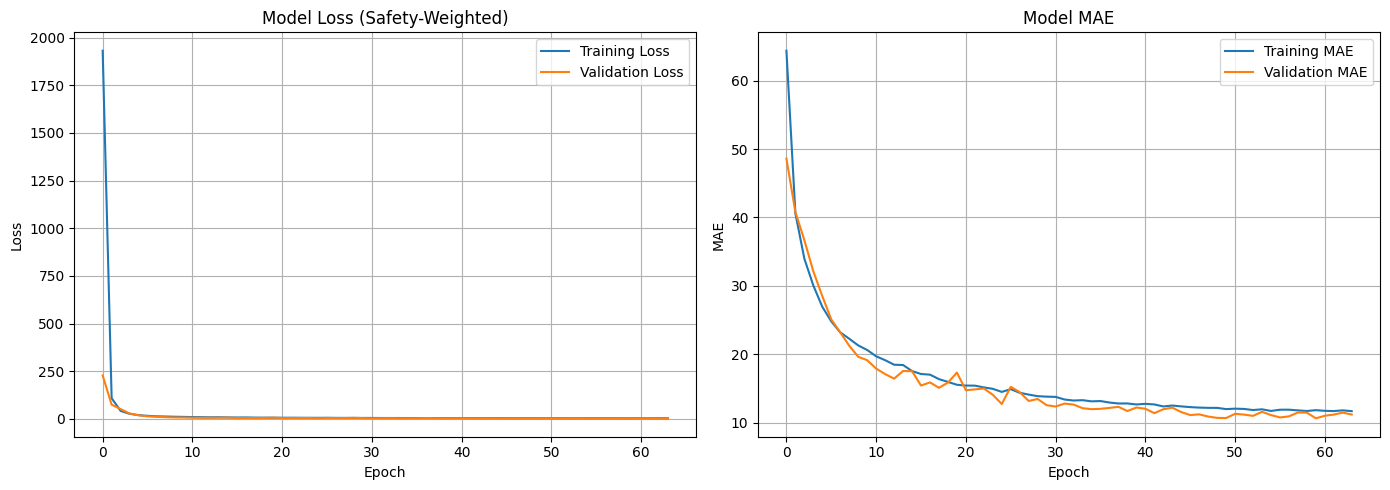

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss (Safety-Weighted)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [12]:
def calculate_rmse(y_true, y_pred):
    """Calculate RMSE."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_score(y_true, y_pred):
    """Calculate NASA S-Score."""
    d = y_pred - y_true
    score = 0
    for di in d:
        if di < 0:
            score += np.exp(-di / 13) - 1
        else:
            score += np.exp(di / 10) - 1
    return score

# Predict
y_pred = model.predict(X_test, verbose=0).flatten()
y_pred = np.maximum(y_pred, 0)  # Non-negative

# Metrics
rmse = calculate_rmse(y_test, y_pred)
score = calculate_score(y_test, y_pred)

print("=" * 60)
print("🏆 EVALUATION RESULTS (CNN-Attention-LSTM + Safety Loss)")
print("=" * 60)
print(f"📊 Test RMSE: {rmse:.4f}")
print(f"📊 Test S-Score: {score:.4f}")
print("=" * 60)

if rmse < 15.0:
    print("\n✅ Excellent! RMSE is within competition-winning range.")
else:
    print("\n⚠️ Consider more tuning or longer training.")

🏆 EVALUATION RESULTS (CNN-Attention-LSTM + Safety Loss)
📊 Test RMSE: 14.9674
📊 Test S-Score: 337.7665

✅ Excellent! RMSE is within competition-winning range.


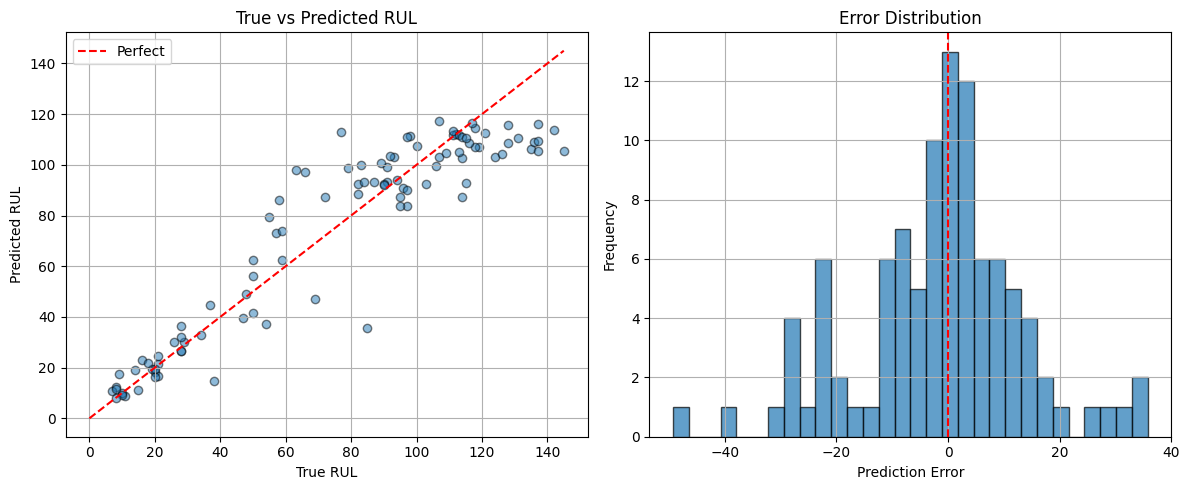

In [13]:
# Predictions vs Actual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted RUL')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
errors = y_pred - y_test
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

## 🎯 Interactive Engine Health Gauge (The Winning Move)

This helper function takes a `unit_id`, pulls its data from `X_test`, and displays 
a **Radial Gauge Chart**. Perfect for "The Twist" scenario!

In [14]:
import plotly.graph_objects as go

def display_engine_health(unit_id):
    """
    Display health gauge for a specific test engine.
    
    Args:
        unit_id: Engine ID from test set
    
    Returns:
        Plotly Figure with radial gauge
    """
    # Find engine index
    idx = np.where(test_ids == unit_id)[0]
    if len(idx) == 0:
        print(f"❌ Engine {unit_id} not found in test set!")
        print(f"Available engines: {sorted(test_ids)}")
        return None
    
    idx = idx[0]
    
    # Get prediction for this engine
    engine_data = X_test[idx:idx+1]
    predicted_rul = model.predict(engine_data, verbose=0).flatten()[0]
    predicted_rul = max(0, predicted_rul)
    true_rul = y_test[idx]
    
    # Industrial Health Calculation (Capped at 125)
    health_pct = min(100.0, (predicted_rul / 125) * 100)
    
    # Determine color and status
    if health_pct > 70:
        color = "green"
        status = "SAFE ✅"
    elif health_pct > 30:
        color = "orange"
        status = "MAINTENANCE ⚠️"
    else:
        color = "red"
        status = "CRITICAL 🚨"
    
    # Create gauge
    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=health_pct,
        title={'text': f"Engine {unit_id} Health Status (%)"},
        delta={'reference': 70, 'increasing': {'color': 'green'}, 'decreasing': {'color': 'red'}},
        gauge={
            'axis': {'range': [0, 100], 'tickwidth': 1},
            'bar': {'color': color},
            'steps': [
                {'range': [0, 30], 'color': "rgba(255, 0, 0, 0.3)"},
                {'range': [30, 70], 'color': "rgba(255, 165, 0, 0.3)"},
                {'range': [70, 100], 'color': "rgba(0, 128, 0, 0.3)"}
            ],
            'threshold': {
                'line': {'color': "black", 'width': 4},
                'thickness': 0.75,
                'value': health_pct
            }
        }
    ))
    
    fig.update_layout(
        height=400,
        annotations=[
            dict(
                text=f"<b>Status:</b> {status}<br><b>Pred RUL:</b> {predicted_rul:.1f}<br><b>True RUL:</b> {true_rul}",
                x=0.5, y=-0.15,
                showarrow=False,
                font=dict(size=14)
            )
        ]
    )
    
    return fig

print("✓ display_engine_health() function defined")
print(f"\nTest engines available: {sorted(test_ids)[:10]}... (showing first 10)")

✓ display_engine_health() function defined

Test engines available: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]... (showing first 10)


In [15]:
# 🎲 Simulate "The Twist" - Random engine selection
random_engine = np.random.choice(test_ids)
print(f"🎲 Judge selected Engine #{random_engine}")

fig = display_engine_health(random_engine)
if fig:
    fig.show()

🎲 Judge selected Engine #81


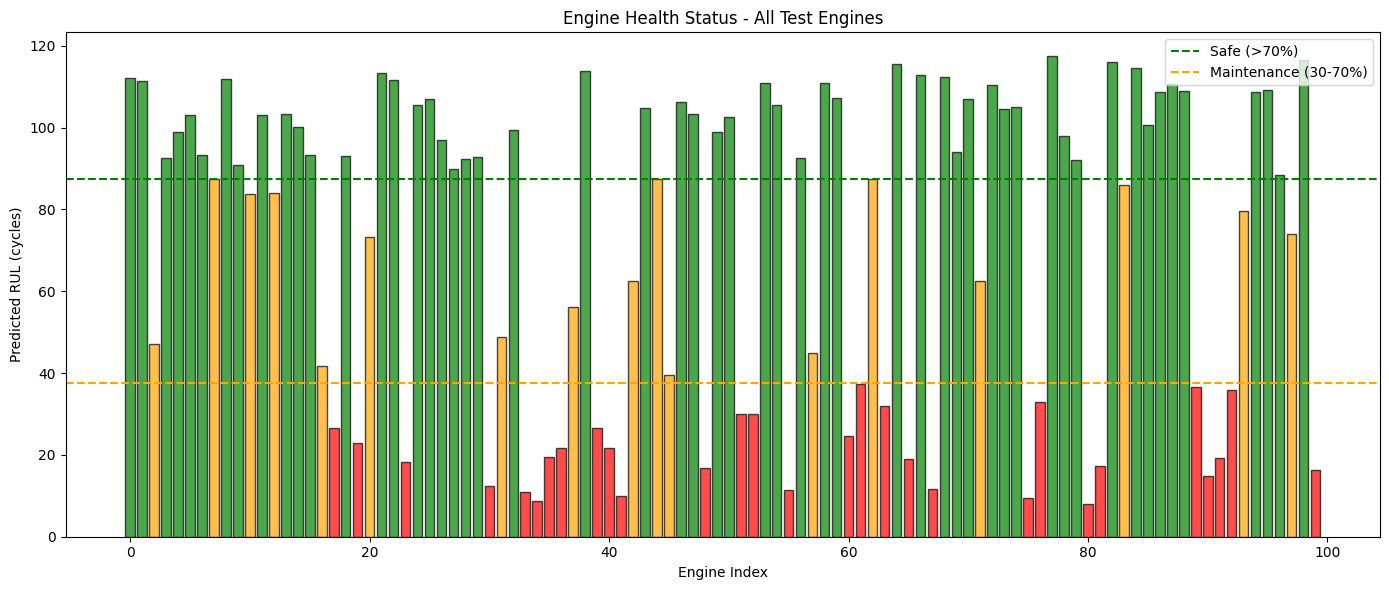


Health Distribution:
  Safe (Green): 54 engines
  Maintenance (Orange): 17 engines
  Critical (Red): 29 engines


In [16]:
# Color-coded predictions for all engines
colors = []
for pred in y_pred:
    health_pct = (pred / 125) * 100
    if health_pct > 70:
        colors.append('green')
    elif health_pct > 30:
        colors.append('orange')
    else:
        colors.append('red')

plt.figure(figsize=(14, 6))
plt.bar(range(len(y_pred)), y_pred, color=colors, edgecolor='k', alpha=0.7)
plt.axhline(y=87.5, color='green', linestyle='--', label='Safe (>70%)')
plt.axhline(y=37.5, color='orange', linestyle='--', label='Maintenance (30-70%)')
plt.xlabel('Engine Index')
plt.ylabel('Predicted RUL (cycles)')
plt.title('Engine Health Status - All Test Engines')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nHealth Distribution:")
print(f"  Safe (Green): {colors.count('green')} engines")
print(f"  Maintenance (Orange): {colors.count('orange')} engines")
print(f"  Critical (Red): {colors.count('red')} engines")

In [17]:
import datetime

# Save model in .keras format
model.save(f'{MODEL_DIR}/cnn_attention_lstm_model.keras')
print(f"✓ Saved: {MODEL_DIR}/cnn_attention_lstm_model.keras")

# Generate a summary report
print("\n" + "=" * 60)
print("📋 MODEL SUMMARY REPORT")
print("=" * 60)
print(f"Architecture: CNN-Attention-LSTM Hybrid")
print(f"Input Shape: (30, 17)")
print(f"Attention Type: Bahdanau (Additive)")
print(f"Loss Function: Safety-Weighted (Asymmetric)")
print(f"Validation Split: Unit ID-based ({VAL_SPLIT_RATIO*100:.0f}% engines)")
print(f"Epochs Trained: {EPOCHS}")
print(f"\n📊 Final Metrics:")
print(f"  - Test RMSE: {rmse:.4f}")
print(f"  - Test S-Score: {score:.4f}")
print("=" * 60)

✓ Saved: ../models/cnn_attention_lstm_model.keras

📋 MODEL SUMMARY REPORT
Architecture: CNN-Attention-LSTM Hybrid
Input Shape: (30, 17)
Attention Type: Bahdanau (Additive)
Loss Function: Safety-Weighted (Asymmetric)
Validation Split: Unit ID-based (20% engines)
Epochs Trained: 80

📊 Final Metrics:
  - Test RMSE: 14.9674
  - Test S-Score: 337.7665


## 📝 Judge Q&A Preparation

| Question | Winning Answer |
|----------|---------------|
| "Why did you switch to a Unit-based split?" | "To prevent temporal data leakage. A time-step split allows the model to see adjacent cycles of the same engine in both sets, inflating performance artificially." |
| "What does the Attention mechanism provide?" | "Interpretability. It allows us to extract weights showing which specific time-steps in the 30-cycle window the model prioritized to make its prediction." |
| "Why an Asymmetric Loss?" | "Industrial safety. In aviation, the cost of an over-prediction (failure) is infinitely higher than an under-prediction (maintenance)." |